In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def pdfnvar(x, m, K, n=2):
    x = np.asarray(x).reshape(-1)  # Garante que x é um vetor 1D
    m = np.asarray(m).reshape(-1)  # Garante que m é um vetor 1D
    diff = x - m
    exponent = -0.5 * np.dot(diff.T, np.linalg.solve(K, diff))  # Usa np.linalg.solve para evitar problemas
    denominator = np.sqrt((2 * np.pi) ** n * np.linalg.det(K))
    return (1 / denominator) * np.exp(exponent)

def knn_dist_vect(X, Y, xt, k , h=0.5):
    dist = (((X.T-xt).T)**2).sum(axis=1)
    n = X.shape[1]
    K = h*np.eye(n)
    sum_neg = 0
    sum_pos = 0
    for datapoint,label in zip(X[dist.argsort()[:k]],Y[dist.argsort()[:k]]):
        if label ==1:
            sum_pos += label * pdfnvar(datapoint, xt, K, n)
        else:
            sum_neg += label * pdfnvar(datapoint, xt, K, n)
    pred = np.sign((sum_pos+sum_neg))
    pred_vec = np.array([sum_pos,-1*sum_neg])
    return pred, pred_vec

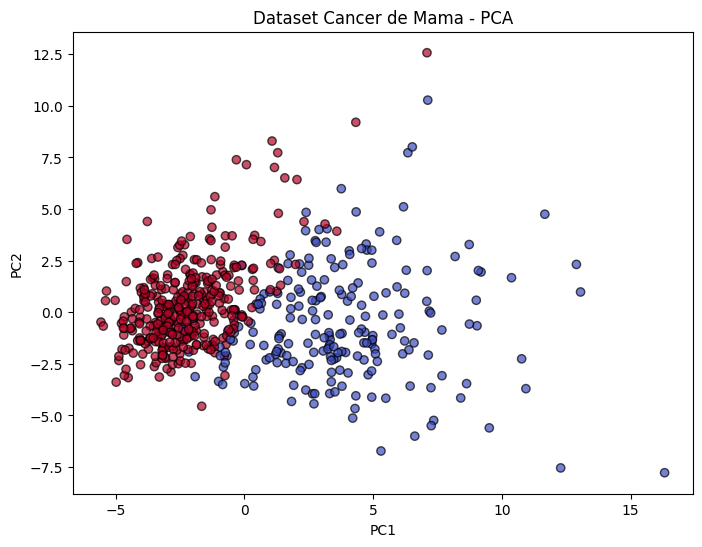

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Carregando dataset de câncer de mama
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Padronizando e reduzindo dimensões
X = StandardScaler().fit_transform(X)
X = PCA(n_components=2).fit_transform(X)

# Convertendo labels para -1 e 1
y = np.where(y == 0, -1, 1)

# Visualizando dados após PCA
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Dataset Cancer de Mama - PCA')
plt.show()

In [3]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns

# Definindo os ranges para k e h
ks = np.arange(1, 101, 2)
print(ks.shape)
hs = np.logspace(np.log10(100), np.log10(0.00001), 50) 
print(hs.shape)
n_repeticoes = 5  # Número de repetições
print(n_repeticoes*ks.shape[0]*hs.shape[0])

# Dicionário para armazenar resultados
resultados = {(k, h): [] for k in ks for h in hs}

for repeticao in range(n_repeticoes):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=repeticao)
    
    # Calculando o total de iterações para esta repetição
    total_iteracoes = len(ks) * len(hs) * len(X_test)
    progress_bar = tqdm(total=total_iteracoes, desc=f"Repetição {repeticao+1}/{n_repeticoes}")
    
    for k in ks:
        for h in hs:
            test_preds = []
            for xt in X_test:
                pred, pred_vec = knn_dist_vect(X_train, y_train, xt.reshape(2, 1), k=int(k), h=h)
                test_preds.append(pred)
                progress_bar.update(1)
                
            test_preds = np.array(test_preds)
            resultados[(k, h)].append((y_test==test_preds).mean())
    
    progress_bar.close()

# Calcular médias
acuracy_mean = np.zeros((len(ks), len(hs)))
for i, k in enumerate(ks):
    for j, h in enumerate(hs):
        acuracy_mean[i, j] = np.mean(resultados[(k, h)])


(50,)
(50,)
12500


Repetição 5/5: 100%|██████████| 285000/285000 [02:24<00:00, 1968.98it/s]


In [4]:
df_data = []
for i, k in enumerate(ks):
    for j, h in enumerate(hs):
        df_data.append({
            'k': k,
            'h': h,
            'acuracia': acuracy_mean[i, j]
        })

# Criando o DataFrame
import pandas as pd
df_resultados = pd.DataFrame(df_data)

# Opcional: ordenar o DataFrame
df_resultados = df_resultados.sort_values(['k', 'h']).reset_index(drop=True)

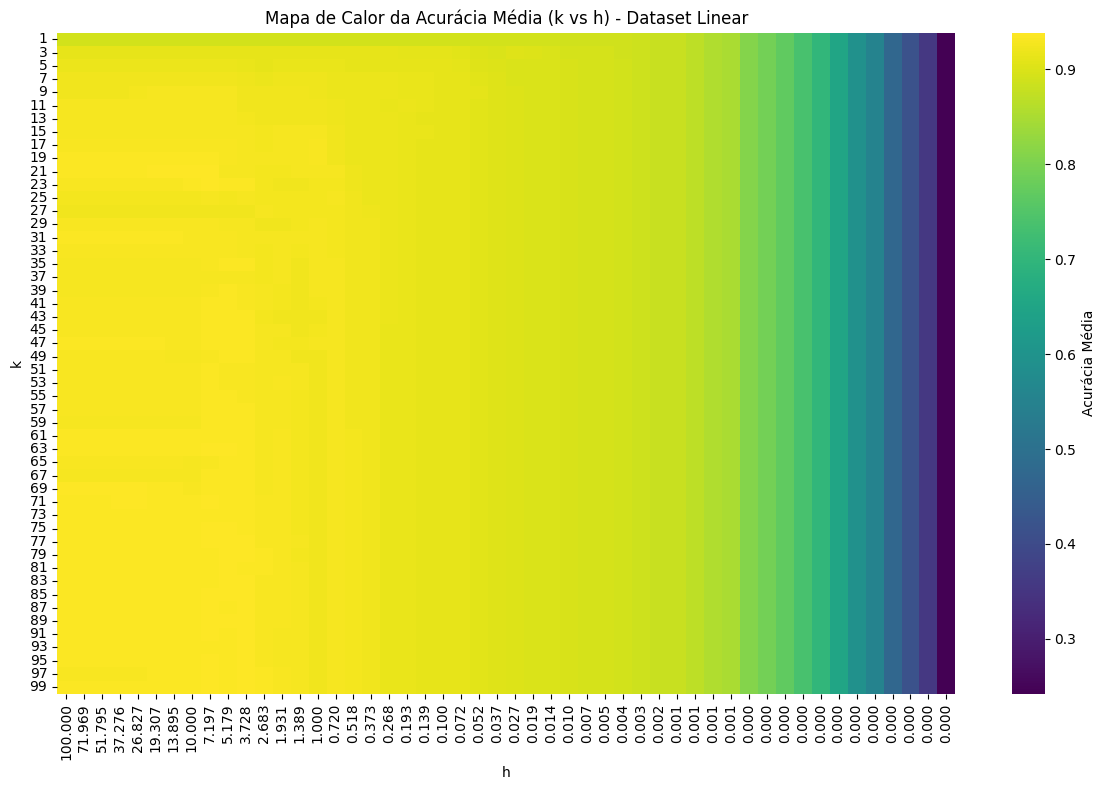

Melhor acurácia: 0.939
Melhor k: 75
Melhor h: 5.179


In [5]:

# Criar o mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(acuracy_mean, 
            xticklabels=[f'{h:.3f}' for h in hs],
            yticklabels=ks,
            cmap='viridis',
            annot=False,
            fmt='.3f',
            cbar_kws={'label': 'Acurácia Média'})

plt.xlabel('h')
plt.ylabel('k')
plt.title('Mapa de Calor da Acurácia Média (k vs h) - Dataset Linear')
plt.tight_layout()
plt.show()

# Encontrar os melhores parâmetros
melhor_acc = np.max(acuracy_mean)
idx_melhor = np.unravel_index(np.argmax(acuracy_mean), acuracy_mean.shape)
melhor_k = ks[idx_melhor[0]]
melhor_h = hs[idx_melhor[1]]

print(f'Melhor acurácia: {melhor_acc:.3f}')
print(f'Melhor k: {melhor_k}')
print(f'Melhor h: {melhor_h:.3f}')

In [6]:
nome_criterio = 'distancia_centroides_q1_q2'

# Coletar Q1, Q2 e y para cada (k, h)
q1_q2 = {(k, h): [] for k in ks for h in hs}

# Calculando total de iterações
total_iteracoes = len(ks) * len(hs) * len(X)
progress_bar = tqdm(total=total_iteracoes, desc="Coletando vetores Q1 e Q2")

for k in ks:
    for h in hs:
        for i, xt in enumerate(X):
            _, vec = knn_dist_vect(X, y, xt.reshape(2, 1), k=int(k), h=h)
            q1_q2[(k, h)].append((vec[0], vec[1], y[i]))
            progress_bar.update(1)

progress_bar.close()


Coletando vetores Q1 e Q2: 100%|██████████| 1422500/1422500 [12:56<00:00, 1833.02it/s]


In [9]:

# Calcular distância entre centróides das classes
total_pares = len(ks) * len(hs)
progress_bar_criterios = tqdm(total=total_pares, desc="Calculando distâncias entre centróides")

criterio = {}
for (k, h), valores in q1_q2.items():
    arr = np.array(valores)
    proj = arr[:, :2]
    labels = arr[:, 2]
    classe1 = proj[labels == 1]
    classe0 = proj[labels == 0]
    
    if len(classe1) > 0 and len(classe0) > 0:
        c1 = classe1.mean(axis=0)
        c0 = classe0.mean(axis=0)
        distancia = np.linalg.norm(c1 - c0)
    else:
        distancia = np.nan

    criterio[(k, h)] = distancia
    progress_bar_criterios.update(1)

progress_bar_criterios.close()

# Adiciona a métrica ao DataFrame
df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

Calculando distâncias entre centróides: 100%|██████████| 2500/2500 [00:00<00:00, 6272.22it/s]


In [10]:
# Calcular distância entre centróides das classes
criterio = {}
for (k, h), valores in q1_q2.items():
    arr = np.array(valores)
    proj = arr[:, :2]
    labels = arr[:, 2]
    
    # Modificando para usar -1 e 1 ao invés de 0 e 1
    classe1 = proj[labels == 1]
    classe_menos1 = proj[labels == -1]
    
    if len(classe1) > 0 and len(classe_menos1) > 0:
        c1 = classe1.mean(axis=0)
        c_menos1 = classe_menos1.mean(axis=0)
        distancia = np.linalg.norm(c1 - c_menos1)
    
    else:
        distancia = np.nan

    criterio[(k, h)] = distancia

# Adiciona a métrica ao DataFrame
df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

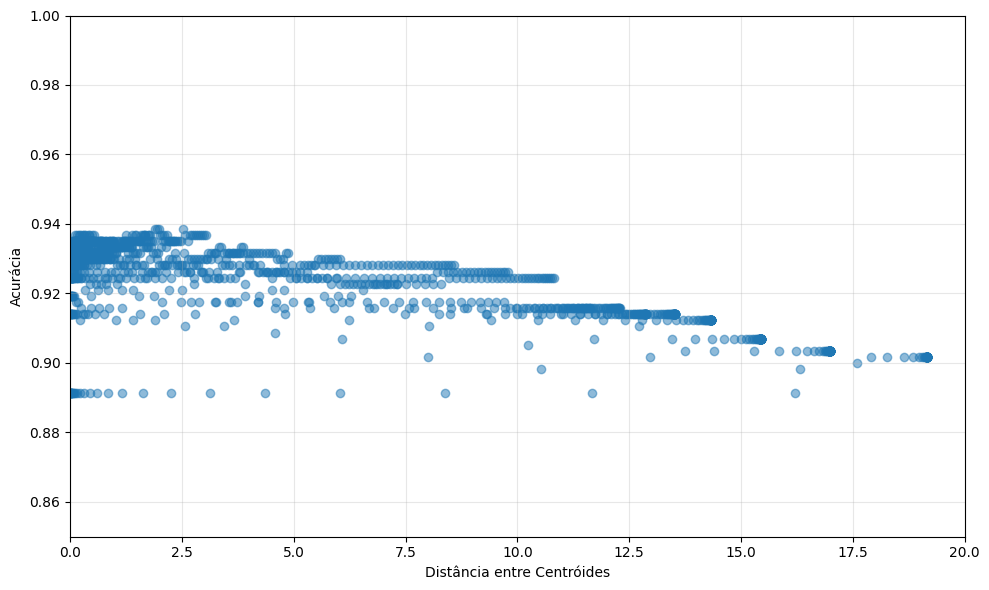

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados['distancia_centroides_q1_q2'], 
           df_resultados['acuracia'],
           alpha=0.5)

plt.xlim(0, 20)  # ajuste estes valores conforme necessário
plt.ylim(0.85, 1)  # ajuste estes valores conforme necessário
plt.xlabel('Distância entre Centróides')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

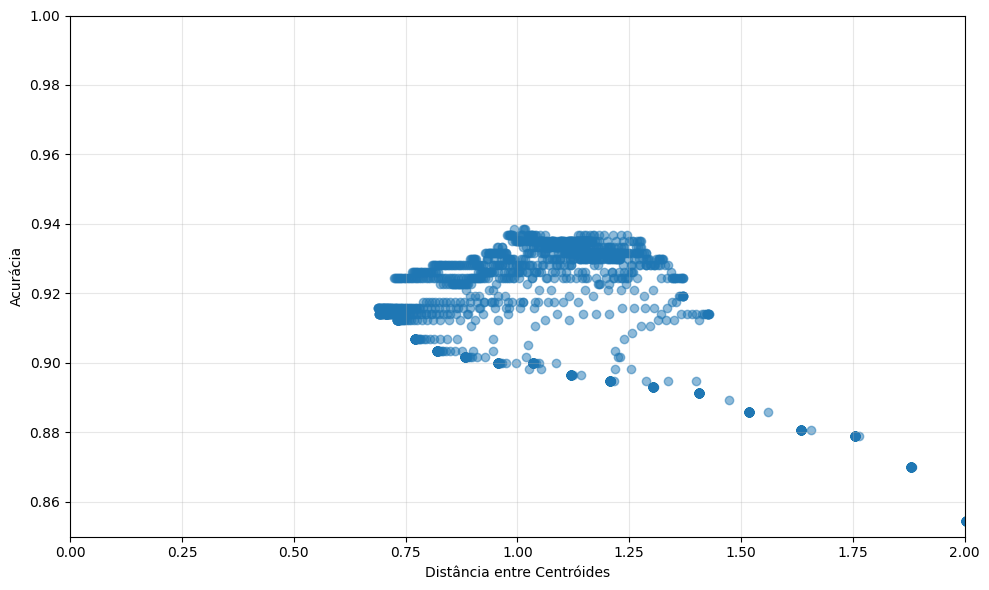

In [12]:
nome_criterio = 'indice_fisher_q1_q2'

criterio = {}
for (k, h), valores in q1_q2.items():
    arr = np.array(valores)
    proj = arr[:, :2]
    labels = arr[:, 2]
    
    classe1 = proj[labels == 1]
    classe_menos1 = proj[labels == -1]
    
    if len(classe1) > 1 and len(classe_menos1) > 1:
        c1 = classe1.mean(axis=0)
        c_m1 = classe_menos1.mean(axis=0)
        dist2 = np.sum((c1 - c_m1) ** 2)
        
        var1 = classe1.var(axis=0).mean()
        var_m1 = classe_menos1.var(axis=0).mean()
        fisher = dist2 / (var1 + var_m1) if (var1 + var_m1) > 0 else np.nan
    else:
        fisher = np.nan

    criterio[(k, h)] = fisher

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

plt.figure(figsize=(10, 6))
plt.scatter(np.log10(df_resultados['indice_fisher_q1_q2']), 
           df_resultados['acuracia'],
           alpha=0.5)

plt.xlim(0, 2)  
plt.ylim(0.85, 1) 
plt.xlabel('Distância entre Centróides')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

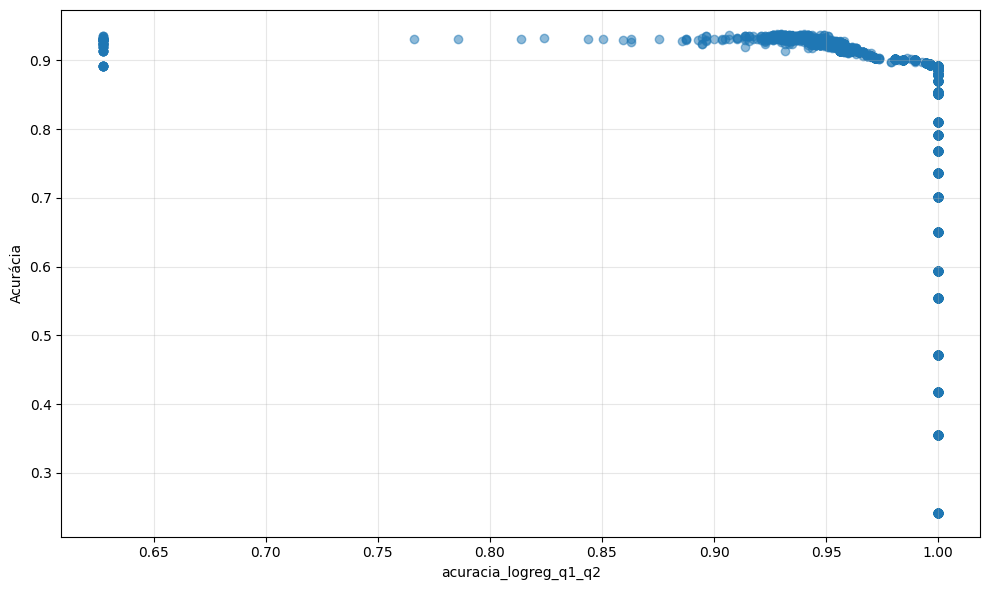

In [13]:
from sklearn.linear_model import LogisticRegression

nome_criterio = 'acuracia_logreg_q1_q2'

criterio = {}
for (k, h), valores in q1_q2.items():
    arr = np.array(valores)
    proj = arr[:, :2]
    labels = arr[:, 2]
    
    if len(np.unique(labels)) == 2:
        try:
            clf = LogisticRegression(solver='lbfgs').fit(proj, labels)
            score = clf.score(proj, labels)
        except:
            score = np.nan
    else:
        score = np.nan

    criterio[(k, h)] = score

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)


plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio], 
           df_resultados['acuracia'],
           alpha=0.5)

# plt.xlim(0, 2)  
# plt.ylim(0.85, 1) 
plt.xlabel(nome_criterio)
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Calculando entropia_q1_q2: 100%|██████████| 2500/2500 [02:38<00:00, 15.75it/s]


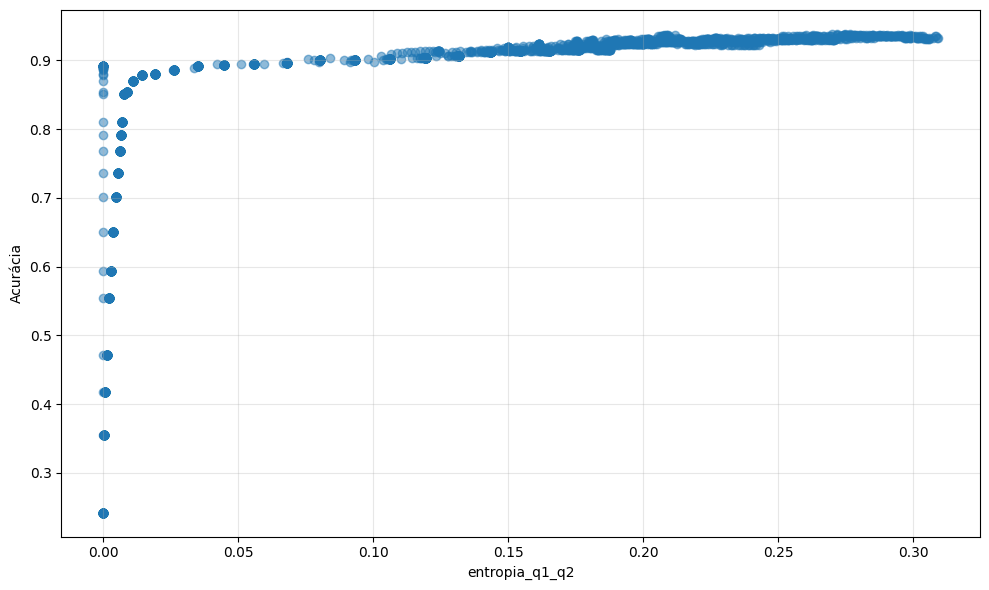

In [14]:
from scipy.stats import entropy
nome_criterio = 'entropia_q1_q2'
criterio = {}

# Loop principal com tqdm externo
for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    probs = []

    # Loop interno com tqdm manual
    for q1, q2, _ in arr:
        total = q1 + abs(q2)
        if total == 0:
            probs.append(0)
        else:
            p1 = q1 / total
            p2 = abs(q2) / total
            probs.append(entropy([p1, p2], base=2))  # entropia binária

    criterio[(k, h)] = np.mean(probs) if probs else np.nan

# Adiciona ao DataFrame
df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio)
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Calculando entropia_condicional_q1_q2: 100%|██████████| 2500/2500 [02:38<00:00, 15.78it/s]


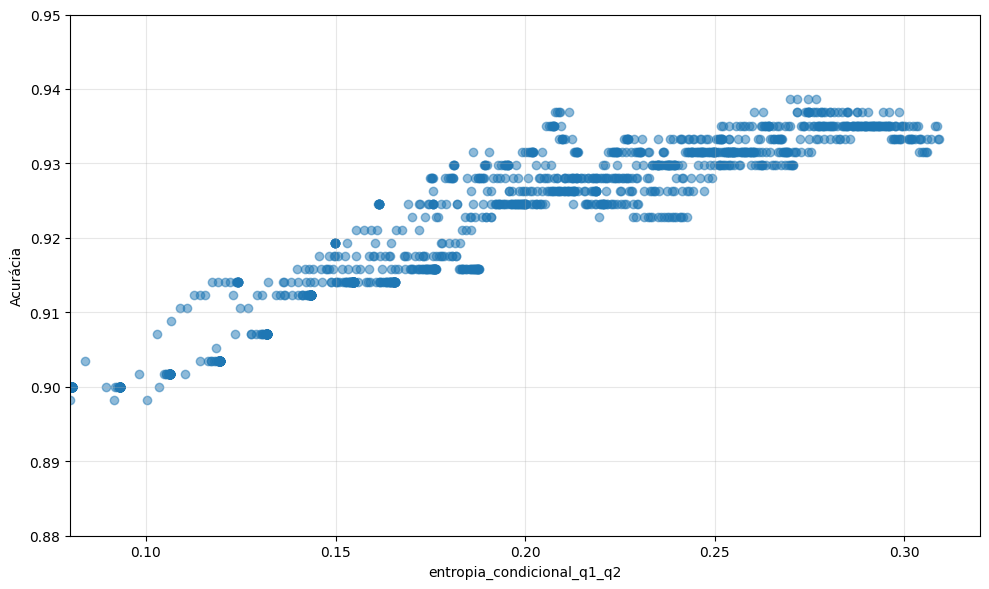

In [15]:
nome_criterio = 'entropia_condicional_q1_q2'
criterio = {}

# Loop principal com tqdm externo
for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    probs = []

    # Loop interno com tqdm manual
    for q1, q2, _ in arr:
        total = q1 + abs(q2)
        if total == 0:
            probs.append(0)
        else:
            p1 = q1 / total
            p2 = abs(q2) / total
            probs.append(entropy([p1, p2], base=2))  # entropia binária

    criterio[(k, h)] = np.mean(probs) if probs else np.nan

# Adiciona ao DataFrame
df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)


# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlim(0.08, 0.32) 
plt.ylim(0.88, 0.95) 
plt.xlabel(nome_criterio)
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Calculando angulo_vetores_classes_q1_q2: 100%|██████████| 2500/2500 [00:00<00:00, 5774.58it/s]


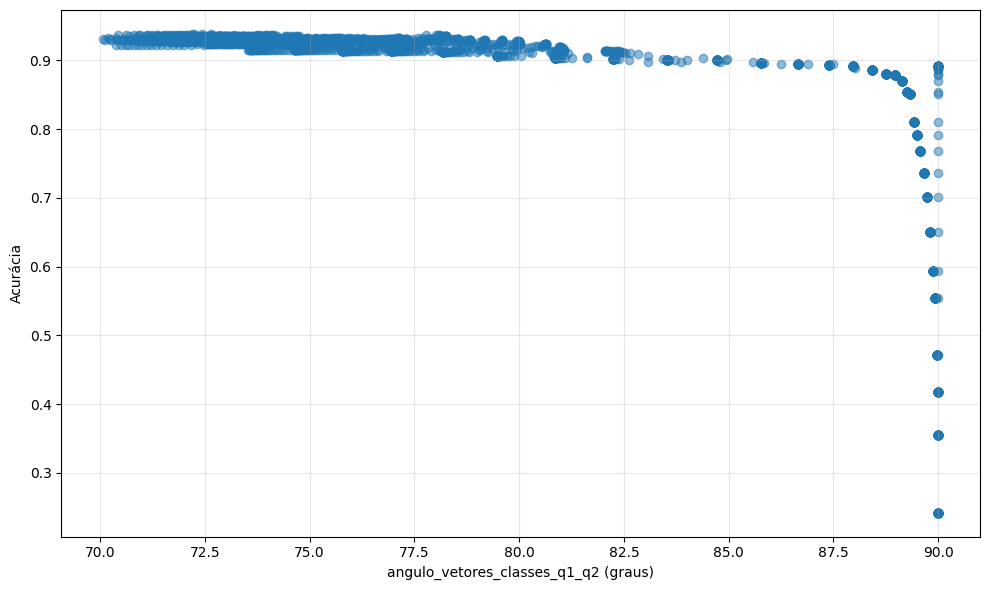

In [16]:
nome_criterio = 'angulo_vetores_classes_q1_q2'
criterio = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    proj = arr[:, :2]
    labels = arr[:, 2]

    classe1 = proj[labels == 1]
    classe_m1 = proj[labels == -1]

    if len(classe1) > 0 and len(classe_m1) > 0:
        v1 = classe1.mean(axis=0)
        v2 = classe_m1.mean(axis=0)

        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)

        if norm_v1 > 0 and norm_v2 > 0:
            cos_theta = np.clip(np.dot(v1, v2) / (norm_v1 * norm_v2), -1.0, 1.0)
            angulo = np.arccos(cos_theta) * 180 / np.pi  # em graus
        else:
            angulo = np.nan
    else:
        angulo = np.nan

    criterio[(k, h)] = angulo

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (graus)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


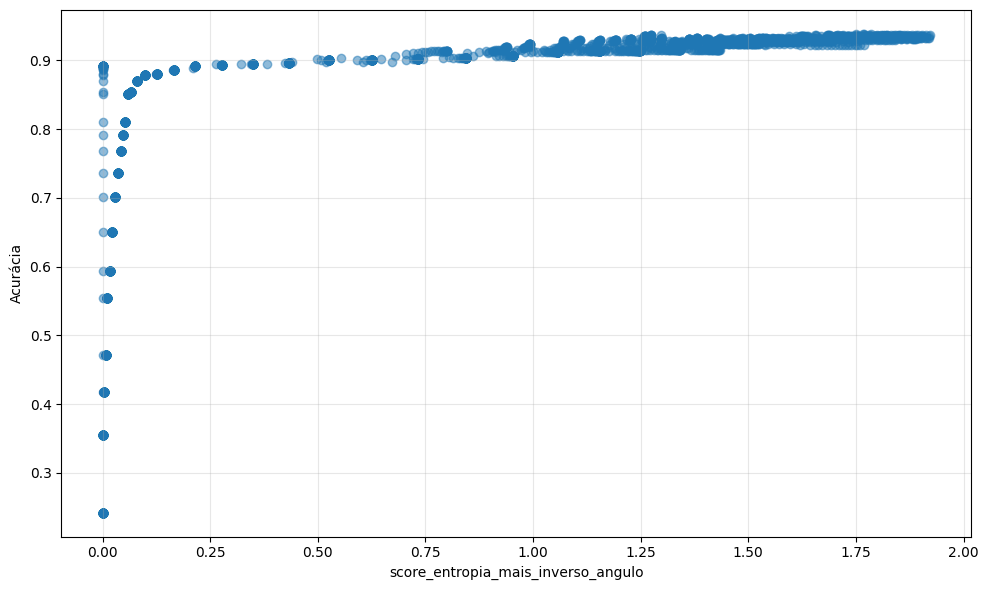

In [17]:
from sklearn.preprocessing import MinMaxScaler

nome_criterio_combinado = 'score_entropia_mais_inverso_angulo'

# Pega os dados válidos
validos = df_resultados[['entropia_q1_q2', 'angulo_vetores_classes_q1_q2']].dropna()

# Normaliza entropia diretamente (maior é melhor)
entropia_norm = MinMaxScaler().fit_transform(validos[['entropia_q1_q2']])

# Normaliza o ângulo invertido (menor ângulo = melhor → maior score)
angulo_invertido = -validos[['angulo_vetores_classes_q1_q2']]
angulo_norm = MinMaxScaler().fit_transform(angulo_invertido)

# Soma normalizada
score_combinado = entropia_norm + angulo_norm

# Atualiza no DataFrame original
df_resultados[nome_criterio_combinado] = np.nan
df_resultados.loc[validos.index, nome_criterio_combinado] = score_combinado

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio_combinado],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio_combinado)
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando razao_intra_interclasse_q1_q2: 100%|██████████| 2500/2500 [00:00<00:00, 2752.30it/s]


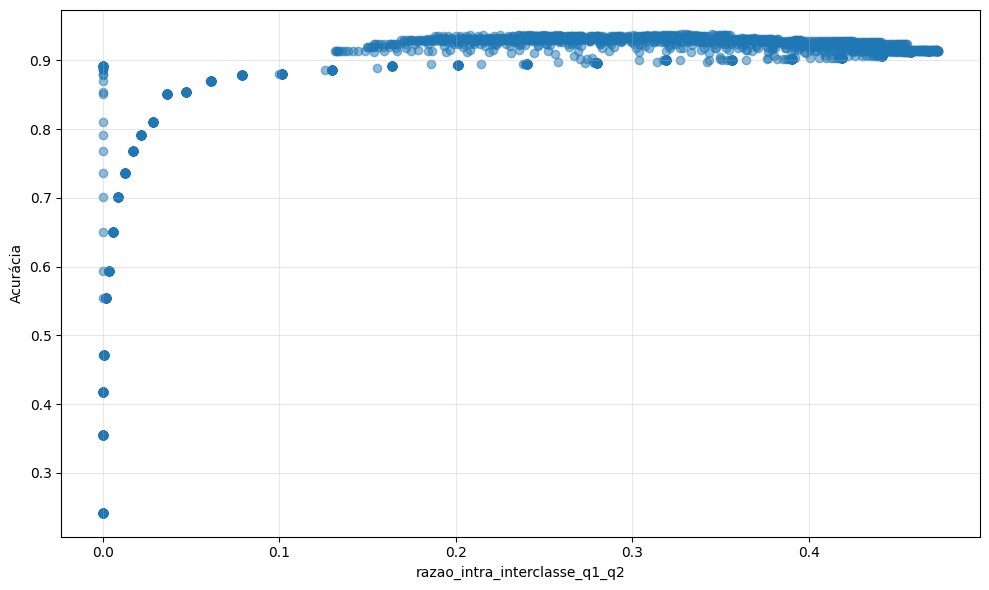

In [18]:
from scipy.spatial.distance import pdist

nome_criterio = 'razao_intra_interclasse_q1_q2'
criterio = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    proj = arr[:, :2]
    labels = arr[:, 2]

    classe1 = proj[labels == 1]
    classe_m1 = proj[labels == -1]

    if len(classe1) > 1 and len(classe_m1) > 1:
        c1_centro = classe1.mean(axis=0)
        c_m1_centro = classe_m1.mean(axis=0)

        interclasse = np.linalg.norm(c1_centro - c_m1_centro)
        intra1 = pdist(classe1).mean() if len(classe1) > 1 else 0
        intra_m1 = pdist(classe_m1).mean() if len(classe_m1) > 1 else 0
        intraclasse = (intra1 + intra_m1) / 2

        criterio[(k, h)] = intraclasse / interclasse if interclasse > 0 else np.nan
    else:
        criterio[(k, h)] = np.nan

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio)
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Calculando q1_eq_q2_proximos: 100%|██████████| 2500/2500 [00:00<00:00, 6693.37it/s]


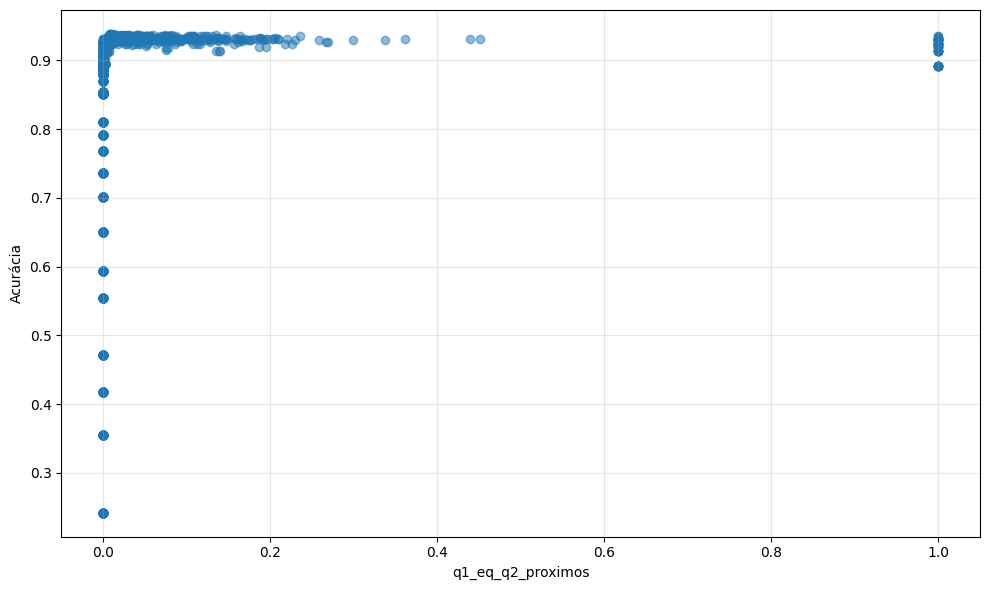

In [19]:
nome_criterio = 'q1_eq_q2_proximos'

criterio = {}
limiar = 0.05  # tolerância para considerar "cruzamento" (|Q1 - Q2| pequeno)

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] == 0:
        criterio[(k, h)] = np.nan
        continue

    q1, q2 = arr[:, 0], arr[:, 1]
    diferenca = np.abs(q1 - q2)
    n_cruzamentos = np.sum(diferenca < limiar)
    proporcao = n_cruzamentos / len(arr)

    criterio[(k, h)] = proporcao

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio)
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
from sklearn.linear_model import LogisticRegression

nome_criterio = 'comprimento_fronteira_logreg_q1_q2'
criterio = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] == 0:
        criterio[(k, h)] = np.nan
        continue

    proj = arr[:, :2]
    labels = arr[:, 2]

    if len(np.unique(labels)) < 2:
        criterio[(k, h)] = np.nan
        continue

    try:
        clf = LogisticRegression(solver='lbfgs').fit(proj, labels)
        coef = clf.coef_[0]
        intercept = clf.intercept_[0]

        # A equação da fronteira é: coef[0]*Q1 + coef[1]*Q2 + intercept = 0
        # Podemos calcular onde essa reta cruza as bordas do domínio para estimar seu comprimento

        q1_min, q1_max = proj[:, 0].min(), proj[:, 0].max()
        q2_min, q2_max = proj[:, 1].min(), proj[:, 1].max()

        points = []

        # Cruzamento com as bordas horizontais (Q2 = min ou max)
        for q2 in [q2_min, q2_max]:
            if coef[0] != 0:
                q1 = -(coef[1]*q2 + intercept)/coef[0]
                if q1_min <= q1 <= q1_max:
                    points.append((q1, q2))

        # Cruzamento com as bordas verticais (Q1 = min ou max)
        for q1 in [q1_min, q1_max]:
            if coef[1] != 0:
                q2 = -(coef[0]*q1 + intercept)/coef[1]
                if q2_min <= q2 <= q2_max:
                    points.append((q1, q2))

        # Se achamos dois pontos de interseção, estimamos o comprimento da reta dentro do retângulo
        if len(points) >= 2:
            p1, p2 = points[0], points[1]
            comprimento = np.linalg.norm(np.array(p1) - np.array(p2))
        else:
            comprimento = np.nan

    except:
        comprimento = np.nan

    criterio[(k, h)] = comprimento

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)


Calculando comprimento_fronteira_logreg_q1_q2: 100%|██████████| 2500/2500 [00:06<00:00, 364.77it/s]


Calculando mutual_information_q1_q2_y: 100%|██████████| 2500/2500 [00:10<00:00, 236.07it/s]


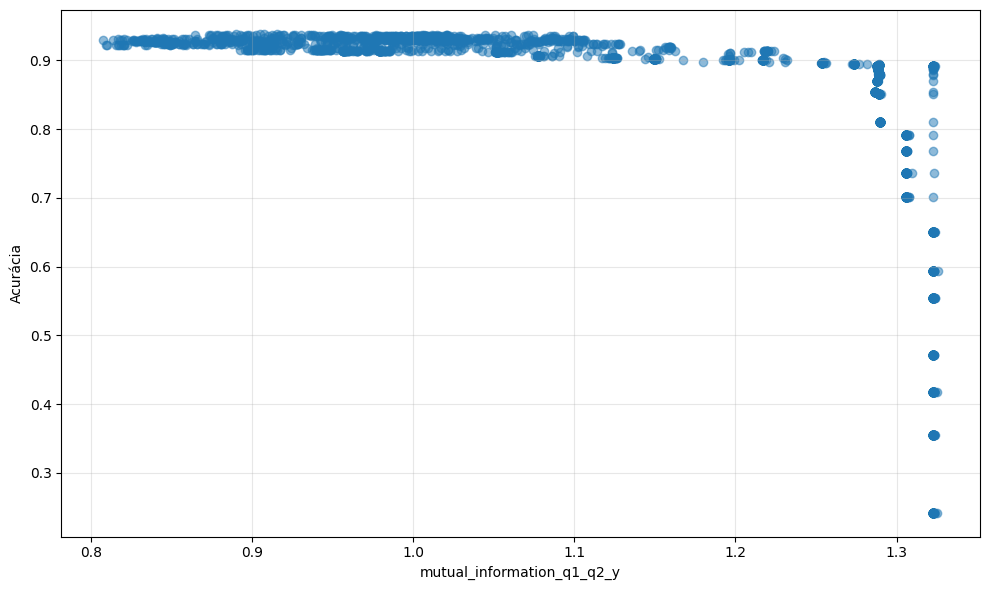

In [21]:
from sklearn.feature_selection import mutual_info_classif
from tqdm import tqdm
import matplotlib.pyplot as plt

nome_criterio = 'mutual_information_q1_q2_y'
criterio = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] == 0:
        criterio[(k, h)] = np.nan
        continue

    proj = arr[:, :2]
    labels = arr[:, 2]

    if len(np.unique(labels)) < 2:
        criterio[(k, h)] = np.nan
        continue

    try:
        mi = mutual_info_classif(proj, labels, discrete_features=False)
        score = mi.sum()  # total mutual information Q1 + Q2
    except:
        score = np.nan

    criterio[(k, h)] = score

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio)
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Calculando desvio_projecao_centroide_q1_q2: 100%|██████████| 2500/2500 [00:00<00:00, 5371.20it/s]


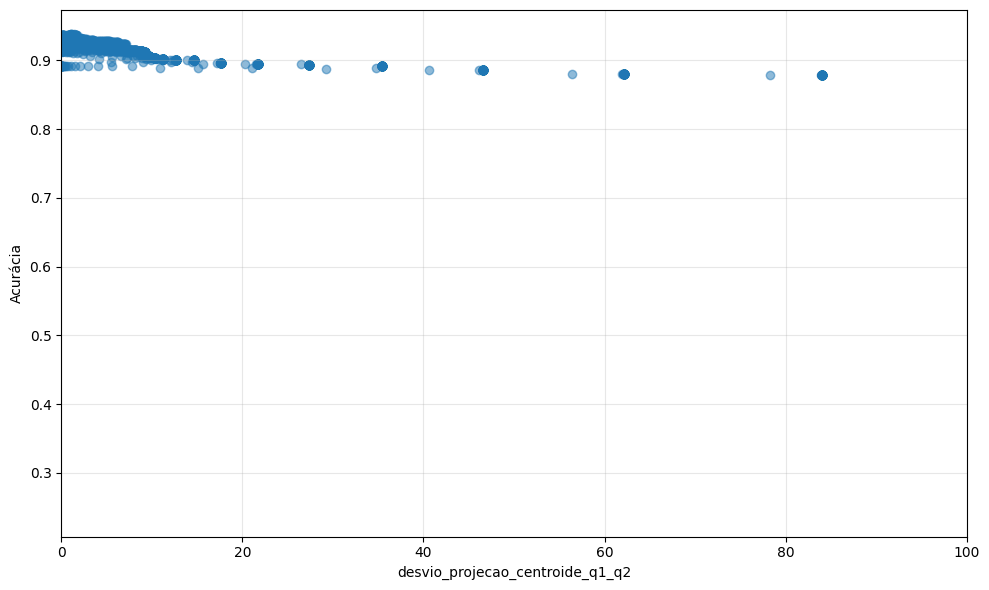

In [22]:
from tqdm import tqdm
import matplotlib.pyplot as plt

nome_criterio = 'desvio_projecao_centroide_q1_q2'
criterio = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    proj = arr[:, :2]
    labels = arr[:, 2]

    classe1 = proj[labels == 1]
    classe_m1 = proj[labels == -1]

    if len(classe1) > 1 and len(classe_m1) > 1:
        c1 = classe1.mean(axis=0)
        c_m1 = classe_m1.mean(axis=0)
        direcao = c_m1 - c1
        direcao /= np.linalg.norm(direcao)

        # Projeta todos os pontos nessa direção
        projecoes = proj @ direcao
        desvio = np.std(projecoes)
    else:
        desvio = np.nan

    criterio[(k, h)] = desvio

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)


# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlim(0, 100)
plt.xlabel(nome_criterio)
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Calculando diferenca_inclinacao_media_q1_q2: 100%|██████████| 2500/2500 [00:00<00:00, 5513.57it/s]


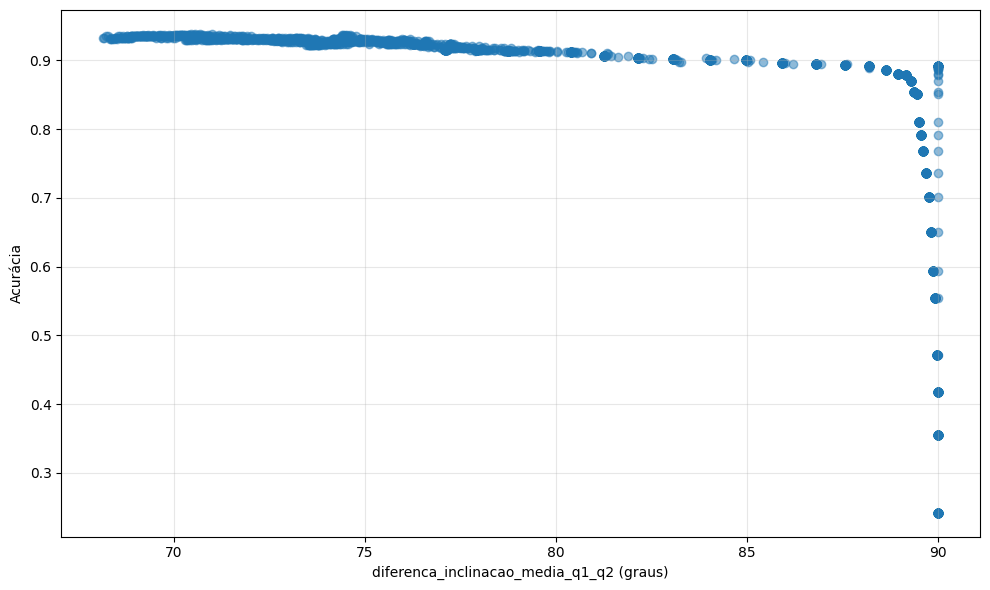

In [23]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

nome_criterio = 'diferenca_inclinacao_media_q1_q2'
criterio = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] == 0:
        criterio[(k, h)] = np.nan
        continue

    proj = arr[:, :2]
    labels = arr[:, 2]

    classe1 = proj[labels == 1]
    classe_m1 = proj[labels == -1]

    if len(classe1) > 0 and len(classe_m1) > 0:
        ang1 = np.arctan2(classe1[:,1], classe1[:,0])
        angm1 = np.arctan2(classe_m1[:,1], classe_m1[:,0])

        ang1_medio = np.mean(ang1)
        angm1_medio = np.mean(angm1)

        diff_ang = np.abs(ang1_medio - angm1_medio)
        diff_ang = min(diff_ang, 2*np.pi - diff_ang)  # garante ângulo no intervalo [0, π]
        criterio[(k, h)] = np.degrees(diff_ang)
    else:
        criterio[(k, h)] = np.nan

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (graus)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando curvatura_fronteira_q1_q2: 100%|██████████| 2500/2500 [00:12<00:00, 201.25it/s]


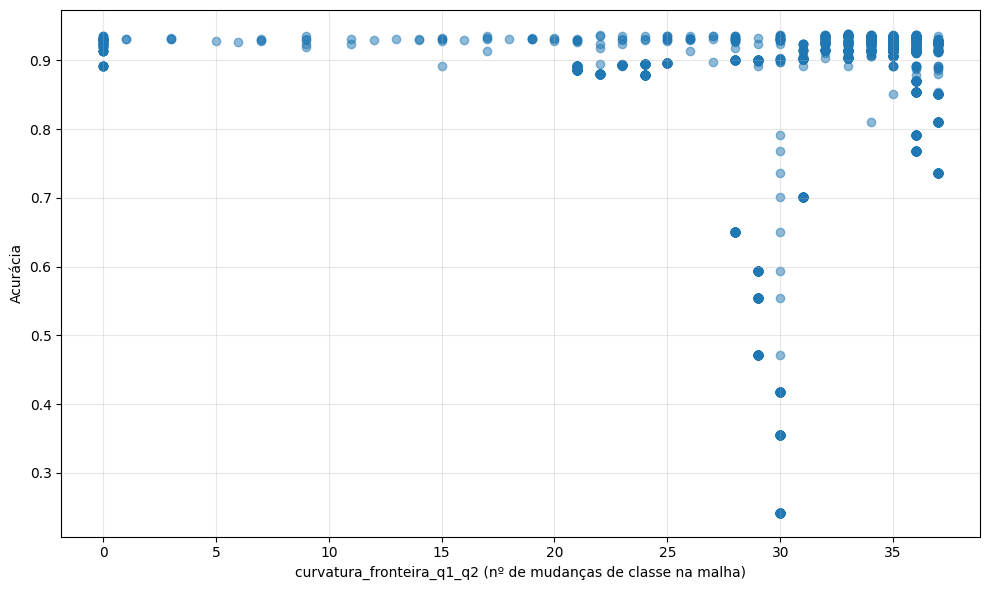

In [24]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

nome_criterio = 'curvatura_fronteira_q1_q2'
criterio = {}
resolucao = 20  # tamanho da malha (grid)

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] == 0:
        criterio[(k, h)] = np.nan
        continue

    X_ = arr[:, :2]
    y_ = arr[:, 2]

    if len(np.unique(y_)) < 2:
        criterio[(k, h)] = np.nan
        continue

    try:
        clf = LogisticRegression(solver='lbfgs').fit(X_, y_)

        # Criar malha no espaço Q1 x Q2
        q1_min, q1_max = X_[:,0].min(), X_[:,0].max()
        q2_min, q2_max = X_[:,1].min(), X_[:,1].max()
        q1_grid = np.linspace(q1_min, q1_max, resolucao)
        q2_grid = np.linspace(q2_min, q2_max, resolucao)
        grid = np.array([[q1, q2] for q1 in q1_grid for q2 in q2_grid])
        preds = clf.predict(grid).reshape((resolucao, resolucao))

        # Contar mudanças de predição entre vizinhos (horizontal + vertical)
        mudancas = 0
        for i in range(resolucao - 1):
            for j in range(resolucao - 1):
                if preds[i, j] != preds[i+1, j]:
                    mudancas += 1
                if preds[i, j] != preds[i, j+1]:
                    mudancas += 1

        criterio[(k, h)] = mudancas

    except:
        criterio[(k, h)] = np.nan

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (nº de mudanças de classe na malha)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando diferenca_skew_q1_q2:   0%|          | 0/2500 [00:00<?, ?it/s]/tmp/ipykernel_99858/661359612.py:21: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew1 = skew(s_c1)
/tmp/ipykernel_99858/661359612.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_1 = skew(s_c_1)
Calculando diferenca_skew_q1_q2: 100%|██████████| 2500/2500 [00:01<00:00, 1476.43it/s]


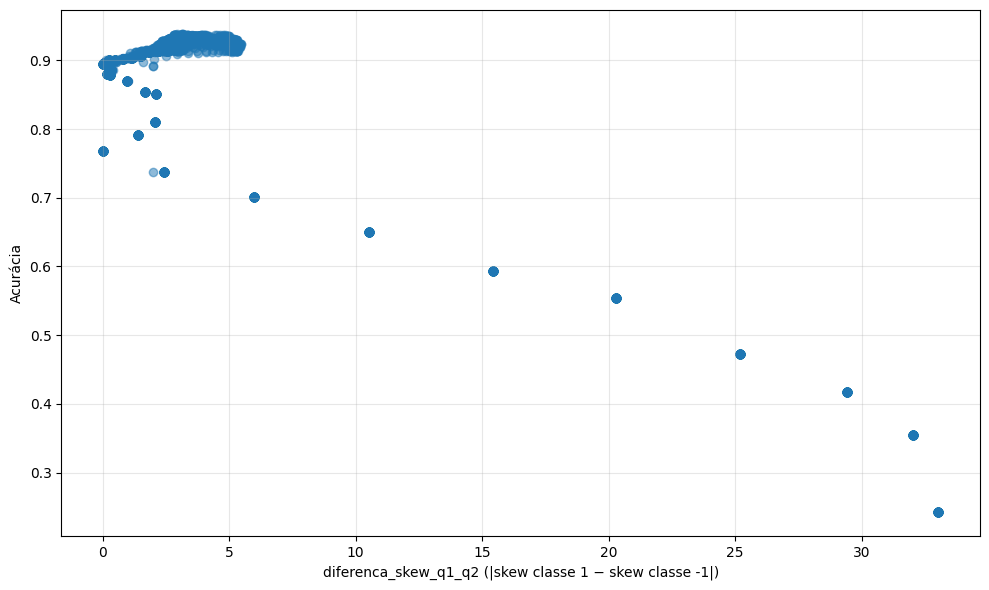

In [25]:
from scipy.stats import skew
import matplotlib.pyplot as plt
from tqdm import tqdm

nome_criterio = 'diferenca_skew_q1_q2'
criterio = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] == 0:
        criterio[(k, h)] = np.nan
        continue

    q1, q2, y = arr[:, 0], arr[:, 1], arr[:, 2]
    s = q1 - q2

    s_c1 = s[y == 1]
    s_c_1 = s[y == -1]

    if len(s_c1) > 2 and len(s_c_1) > 2:
        skew1 = skew(s_c1)
        skew_1 = skew(s_c_1)
        diff = abs(skew1 - skew_1)
    else:
        diff = np.nan

    criterio[(k, h)] = diff

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (|skew classe 1 − skew classe -1|)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando proporcao_baixa_margem_q1_q2: 100%|██████████| 2500/2500 [00:00<00:00, 5934.23it/s]


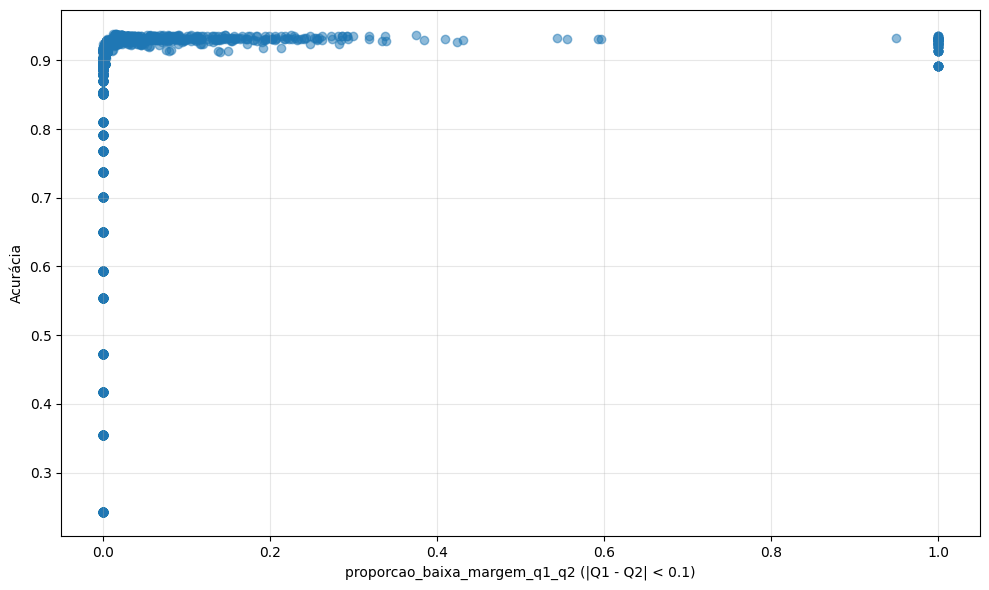

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

nome_criterio = 'proporcao_baixa_margem_q1_q2'
criterio = {}
limiar = 0.1  # margem baixa (ajustável)

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] == 0:
        criterio[(k, h)] = np.nan
        continue

    q1, q2 = arr[:, 0], arr[:, 1]
    margem = np.abs(q1 - q2)
    prop = np.mean(margem < limiar)
    criterio[(k, h)] = prop

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + f' (|Q1 - Q2| < {limiar})')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando distancia_media_signed_q1_q2: 100%|██████████| 2500/2500 [00:00<00:00, 6151.70it/s]


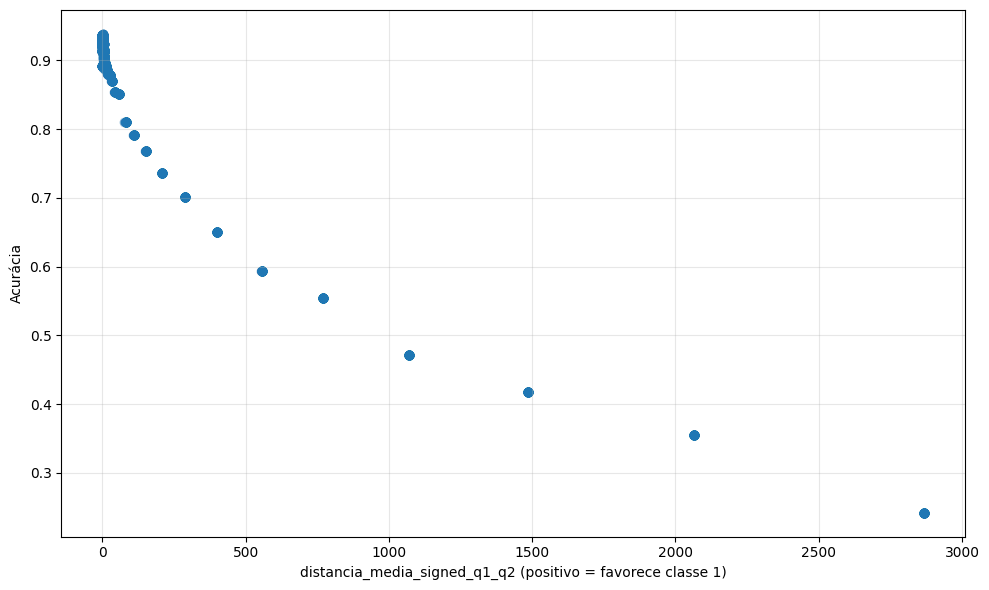

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

nome_criterio = 'distancia_media_signed_q1_q2'
criterio = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] == 0:
        criterio[(k, h)] = np.nan
        continue

    q1 = arr[:, 0]
    q2 = arr[:, 1]

    # Distância com sinal até a reta Q₁ = Q₂
    distancias = (q1 - q2) / np.sqrt(2)
    media_signed = np.mean(distancias)

    criterio[(k, h)] = media_signed

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (positivo = favorece classe 1)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando media_cosseno_direcao_separacao_q1_q2: 100%|██████████| 2500/2500 [00:00<00:00, 4529.09it/s]


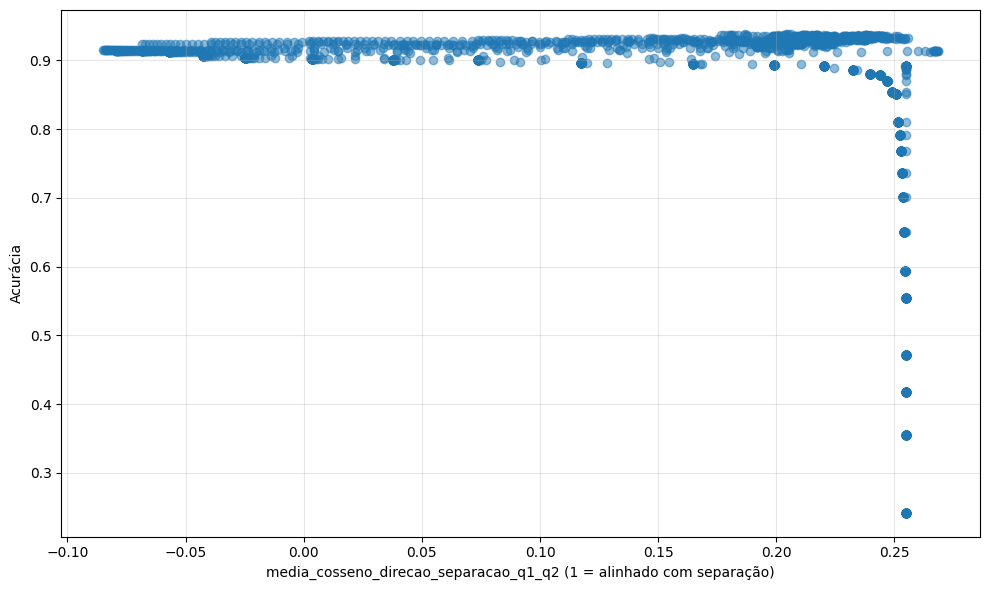

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

nome_criterio = 'media_cosseno_direcao_separacao_q1_q2'
criterio = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    proj = arr[:, :2]
    labels = arr[:, 2]

    classe1 = proj[labels == 1]
    classe_m1 = proj[labels == -1]

    if len(classe1) > 0 and len(classe_m1) > 0:
        centro1 = classe1.mean(axis=0)
        centro_m1 = classe_m1.mean(axis=0)
        vetor_sep = centro1 - centro_m1
        norm_sep = np.linalg.norm(vetor_sep)

        if norm_sep == 0:
            criterio[(k, h)] = np.nan
            continue

        # Vetores dos pontos (do centro do plano até cada ponto)
        vetores = proj - proj.mean(axis=0)
        norm_vetores = np.linalg.norm(vetores, axis=1)

        cossenos = np.dot(vetores, vetor_sep) / (norm_vetores * norm_sep + 1e-9)
        media_cos = np.mean(cossenos)
    else:
        media_cos = np.nan

    criterio[(k, h)] = media_cos

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (1 = alinhado com separação)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando reversoes_fluxo_direcional_q1_q2: 100%|██████████| 2500/2500 [00:01<00:00, 1626.96it/s]


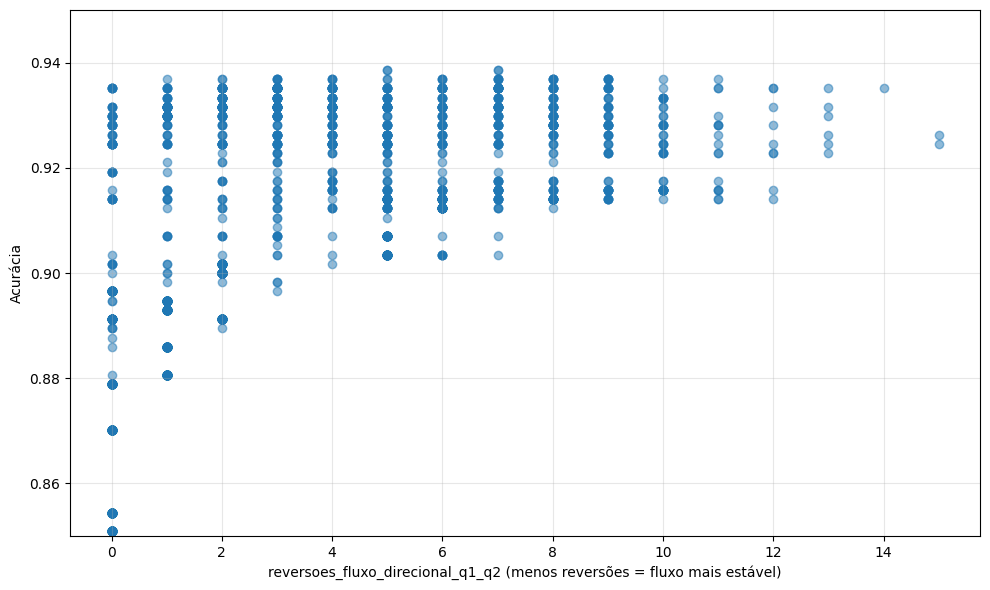

In [29]:
nome_criterio = 'reversoes_fluxo_direcional_q1_q2'
criterio = {}
grid_size = 20

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] == 0:
        criterio[(k, h)] = np.nan
        continue

    q1, q2, y = arr[:, 0], arr[:, 1], arr[:, 2]
    q1_norm = (q1 - q1.min()) / (q1.max() - q1.min() + 1e-9)
    q2_norm = (q2 - q2.min()) / (q2.max() - q2.min() + 1e-9)

    grid = np.zeros((grid_size, grid_size))

    for i in range(len(y)):
        xi = int(q1_norm[i] * (grid_size - 1))
        yi = int(q2_norm[i] * (grid_size - 1))
        grid[yi, xi] += y[i]  # acumula os "vetores de classe"

    # Para cada linha do grid (fixando y), analisa reversões horizontais
    reversoes = 0
    for linha in grid:
        direcoes = np.sign(linha)
        for i in range(1, len(direcoes)):
            if direcoes[i] != 0 and direcoes[i-1] != 0 and direcoes[i] != direcoes[i-1]:
                reversoes += 1

    criterio[(k, h)] = reversoes

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.ylim(0.85, 0.95)
plt.xlabel(nome_criterio + ' (menos reversões = fluxo mais estável)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando energia_repulsao_entre_classes_q1_q2: 100%|██████████| 2500/2500 [00:10<00:00, 240.31it/s]


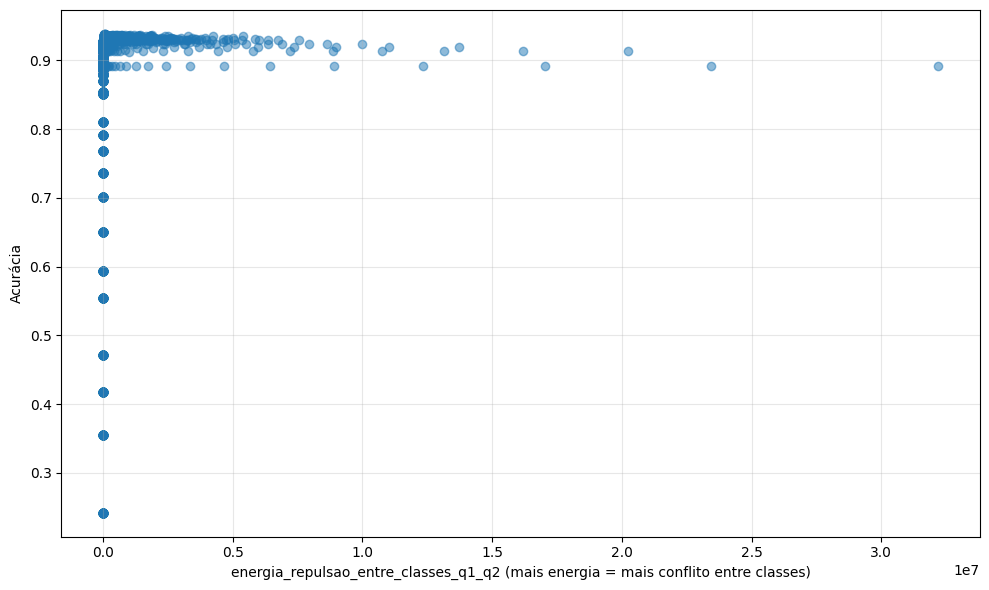

In [30]:
from tqdm import tqdm
import matplotlib.pyplot as plt

nome_criterio = 'energia_repulsao_entre_classes_q1_q2'
criterio = {}
eps = 1e-4  # para evitar divisão por zero

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] == 0:
        criterio[(k, h)] = np.nan
        continue

    proj = arr[:, :2]
    labels = arr[:, 2]

    classe1 = proj[labels == 1]
    classe_m1 = proj[labels == -1]

    if len(classe1) == 0 or len(classe_m1) == 0:
        criterio[(k, h)] = np.nan
        continue

    energia = 0
    for p1 in classe1:
        distancias = np.linalg.norm(classe_m1 - p1, axis=1)
        energia += np.sum(1 / (distancias + eps))

    criterio[(k, h)] = energia

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (mais energia = mais conflito entre classes)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando mudancas_classe_orbita_q1_q2: 100%|██████████| 2500/2500 [00:08<00:00, 302.95it/s]


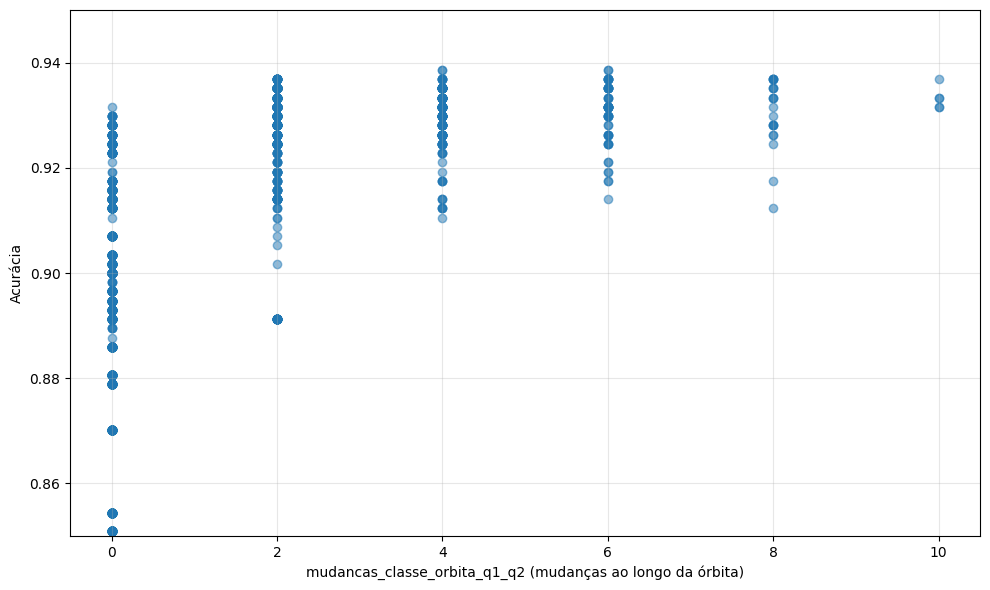

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

nome_criterio = 'mudancas_classe_orbita_q1_q2'
criterio = {}

num_pontos = 100  # pontos na circunferência
raio = 0.5

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] == 0:
        criterio[(k, h)] = np.nan
        continue

    centro = arr[:, :2].mean(axis=0)
    angulos = np.linspace(0, 2*np.pi, num_pontos)
    orbit = np.array([[centro[0] + raio * np.cos(a), centro[1] + raio * np.sin(a)] for a in angulos])

    # Cada ponto da órbita vota pelos k vizinhos mais próximos do conjunto projetado
    votos = []
    for p in orbit:
        dist = np.linalg.norm(arr[:, :2] - p, axis=1)
        idx = dist.argsort()[:5]  # pode ajustar o k do voto
        y_vizinhos = arr[idx, 2]
        classe = np.sign(y_vizinhos.sum())
        votos.append(classe if classe != 0 else np.random.choice([-1, 1]))

    votos = np.array(votos)
    mudancas = np.sum(votos[:-1] != votos[1:])  # conta transições

    criterio[(k, h)] = mudancas

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.ylim(0.85, 0.95)
plt.xlabel(nome_criterio + ' (mudanças ao longo da órbita)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando dominancia_media_anular_q1_q2: 100%|██████████| 2500/2500 [00:00<00:00, 3684.80it/s]


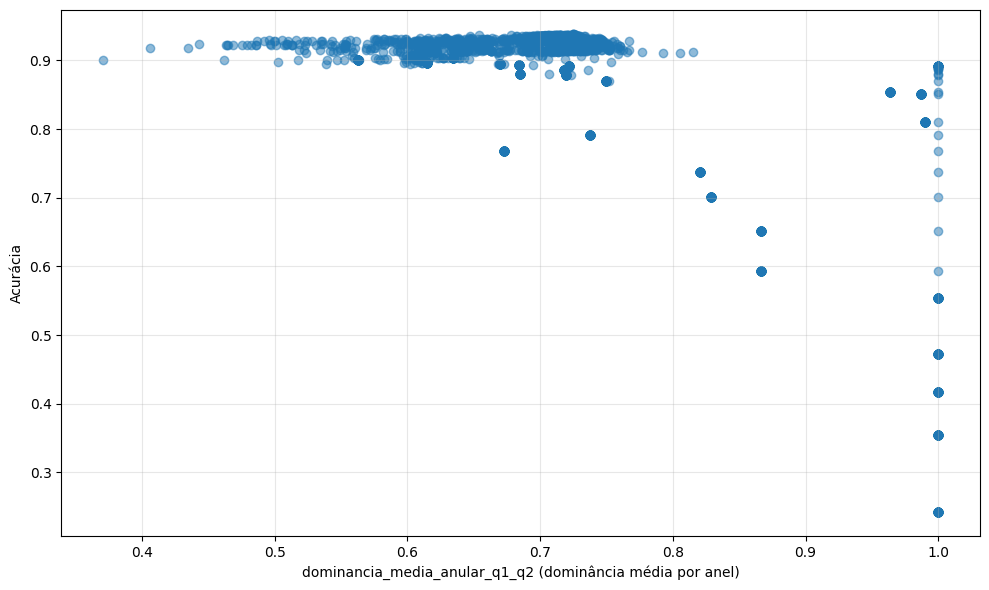

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

nome_criterio = 'dominancia_media_anular_q1_q2'
criterio = {}
n_aneis = 6

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] < 5:
        criterio[(k, h)] = np.nan
        continue

    coords = arr[:, :2]
    labels = arr[:, 2]
    centro = coords.mean(axis=0)

    dist = np.linalg.norm(coords - centro, axis=1)
    max_dist = dist.max()
    bins = np.linspace(0, max_dist + 1e-6, n_aneis + 1)

    dominancias = []
    for i in range(n_aneis):
        mask = (dist >= bins[i]) & (dist < bins[i+1])
        if np.sum(mask) < 3:
            continue
        y_ring = labels[mask]
        p1 = np.mean(y_ring == 1)
        p_1 = np.mean(y_ring == -1)
        dominancia = abs(p1 - p_1)
        dominancias.append(dominancia)

    criterio[(k, h)] = np.mean(dominancias) if dominancias else np.nan

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (dominância média por anel)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando n_componentes_conexos_q1_q2: 100%|██████████| 2500/2500 [00:05<00:00, 484.59it/s]


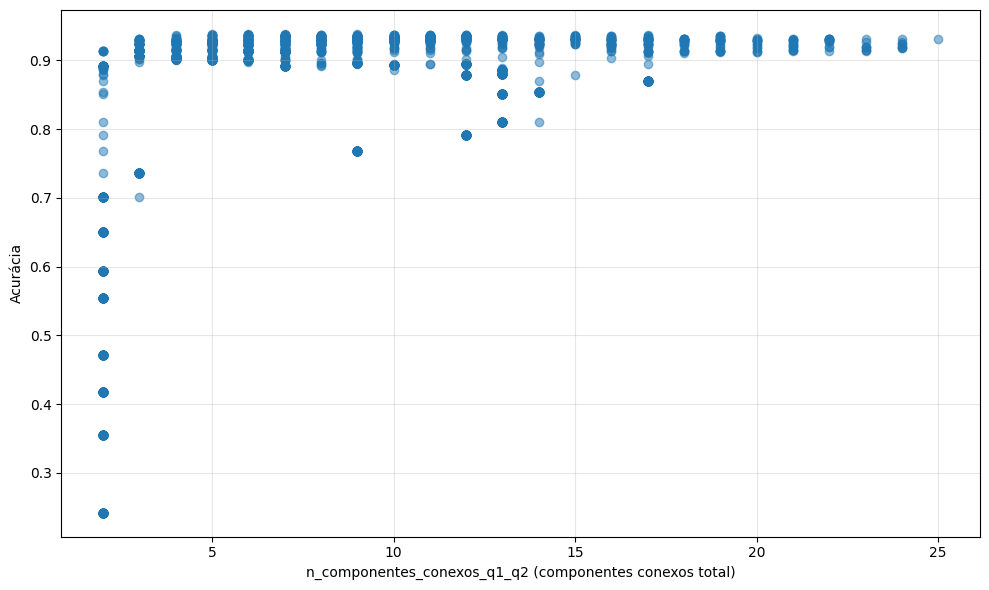

In [33]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
from tqdm import tqdm

nome_criterio = 'n_componentes_conexos_q1_q2'
criterio = {}
k_conexao = 5  # número de vizinhos para conectar os pontos

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] < k_conexao + 1:
        criterio[(k, h)] = np.nan
        continue

    coords = arr[:, :2]
    labels = arr[:, 2]

    total_componentes = 0
    for classe in [1, -1]:
        pontos = coords[labels == classe]
        if len(pontos) <= 1:
            continue
        try:
            nbrs = NearestNeighbors(n_neighbors=min(k_conexao, len(pontos)-1)).fit(pontos)
            grafo = nbrs.kneighbors_graph(pontos, mode='connectivity')
            n_comp, _ = connected_components(grafo)
            total_componentes += n_comp
        except:
            total_componentes += np.nan

    criterio[(k, h)] = total_componentes

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (componentes conexos total)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando variancia_pca_q1_q2: 100%|██████████| 2500/2500 [00:00<00:00, 2619.17it/s]


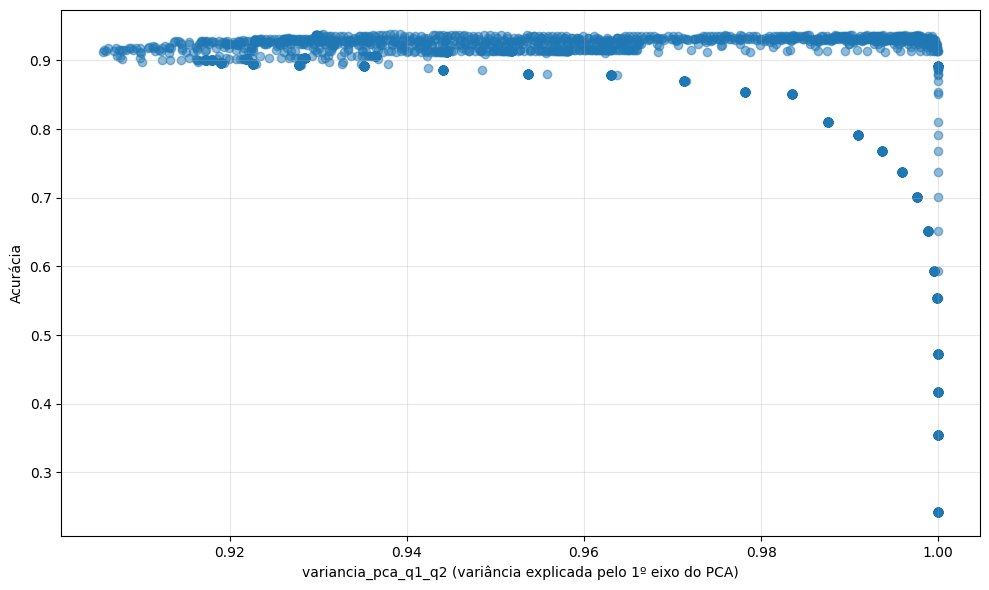

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

nome_criterio = 'variancia_pca_q1_q2'
criterio = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    coords = arr[:, :2]

    if coords.shape[0] < 3:
        criterio[(k, h)] = np.nan
        continue

    try:
        pca = PCA(n_components=2).fit(coords)
        score = pca.explained_variance_ratio_[0]  # quanto da variância está no 1º eixo
    except:
        score = np.nan

    criterio[(k, h)] = score

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (variância explicada pelo 1º eixo do PCA)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando mudancas_classe_espiral_q1_q2: 100%|██████████| 2500/2500 [00:14<00:00, 172.21it/s]


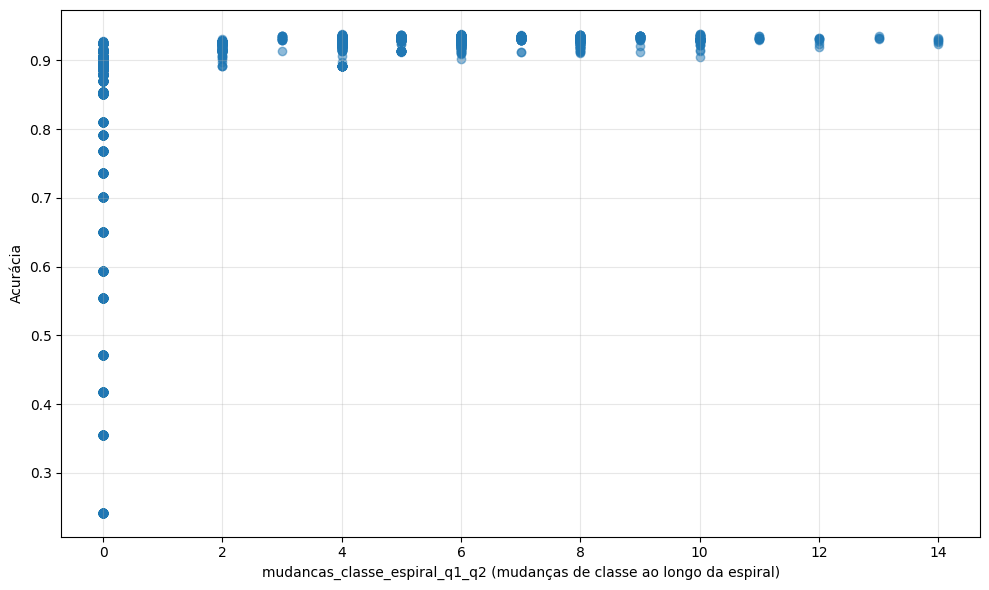

In [35]:
from tqdm import tqdm
import matplotlib.pyplot as plt

nome_criterio = 'mudancas_classe_espiral_q1_q2'
criterio = {}
n_pontos_espiral = 200
raio_max = 1.5 * np.sqrt(2)

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] == 0:
        criterio[(k, h)] = np.nan
        continue

    coords = arr[:, :2]
    labels = arr[:, 2]

    centro = coords.mean(axis=0)
    t = np.linspace(0, 4 * np.pi, n_pontos_espiral)
    r = np.linspace(0, raio_max, n_pontos_espiral)
    espiral = np.stack([
        centro[0] + r * np.cos(t),
        centro[1] + r * np.sin(t)
    ], axis=1)

    # Classifica cada ponto da espiral por voto majoritário dos vizinhos
    classes_espiral = []
    for p in espiral:
        dist = np.linalg.norm(coords - p, axis=1)
        vizinhos = labels[dist.argsort()[:5]]  # voto dos 5 mais próximos
        classe = np.sign(vizinhos.sum())
        classes_espiral.append(classe if classe != 0 else np.random.choice([-1, 1]))

    classes_espiral = np.array(classes_espiral)
    mudancas = np.sum(classes_espiral[:-1] != classes_espiral[1:])

    criterio[(k, h)] = mudancas

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (mudanças de classe ao longo da espiral)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando desequilibrio_quadrantes_q1_q2: 100%|██████████| 2500/2500 [00:01<00:00, 2321.51it/s]


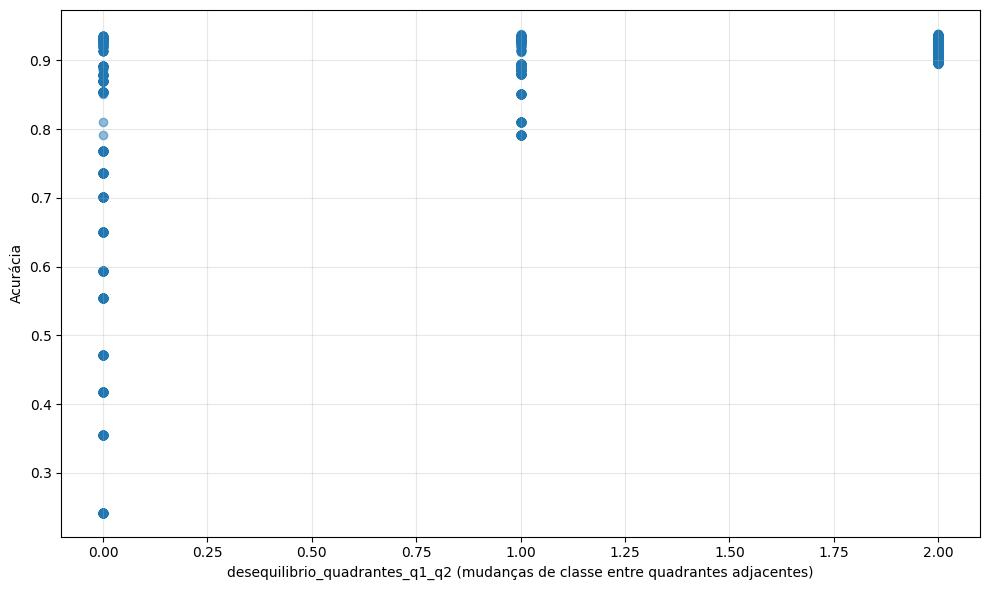

In [36]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

nome_criterio = 'desequilibrio_quadrantes_q1_q2'
criterio = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] < 5:
        criterio[(k, h)] = np.nan
        continue

    q1, q2, y = arr[:, 0], arr[:, 1], arr[:, 2]
    centro_q1, centro_q2 = q1.mean(), q2.mean()

    quadrantes = {
        'Q1': [],
        'Q2': [],
        'Q3': [],
        'Q4': []
    }

    for i in range(len(y)):
        dx = q1[i] - centro_q1
        dy = q2[i] - centro_q2
        if dx >= 0 and dy >= 0:
            quadrantes['Q1'].append(y[i])
        elif dx < 0 and dy >= 0:
            quadrantes['Q2'].append(y[i])
        elif dx < 0 and dy < 0:
            quadrantes['Q3'].append(y[i])
        elif dx >= 0 and dy < 0:
            quadrantes['Q4'].append(y[i])

    sinais = []
    for q in ['Q1', 'Q2', 'Q3', 'Q4']:
        if len(quadrantes[q]) >= 3:
            s = np.sign(np.sum(quadrantes[q]))
            sinais.append(s)
        else:
            sinais.append(0)  # ignorado, mas evita erro

    # Conta número de transições entre quadrantes consecutivos
    mudancas = 0
    for i in range(4):
        a = sinais[i]
        b = sinais[(i+1) % 4]
        if a != 0 and b != 0 and a != b:
            mudancas += 1

    criterio[(k, h)] = mudancas

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (mudanças de classe entre quadrantes adjacentes)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando mudancas_angulo_classe_q1_q2: 100%|██████████| 2500/2500 [00:00<00:00, 3250.10it/s]


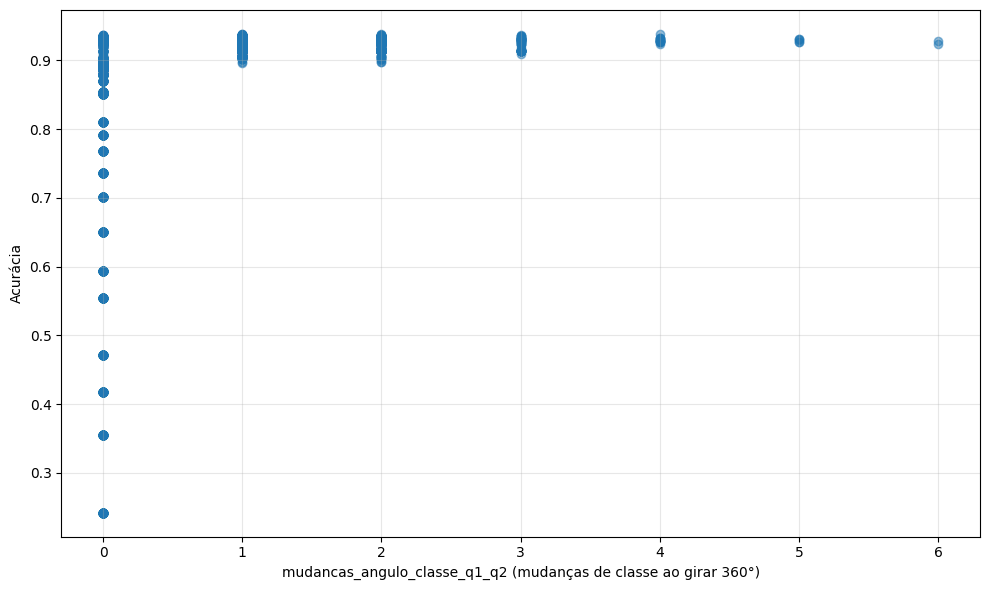

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

nome_criterio = 'mudancas_angulo_classe_q1_q2'
criterio = {}
n_setores = 24  # número de fatias angulares

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] < n_setores:
        criterio[(k, h)] = np.nan
        continue

    coords = arr[:, :2]
    labels = arr[:, 2]
    centro = coords.mean(axis=0)
    vetores = coords - centro

    angulos = np.arctan2(vetores[:, 1], vetores[:, 0])  # range [-π, π]
    angulos = (angulos + 2*np.pi) % (2*np.pi)  # range [0, 2π)
    setores = (angulos / (2*np.pi) * n_setores).astype(int)

    votos = [[] for _ in range(n_setores)]
    for setor, y in zip(setores, labels):
        votos[setor].append(y)

    classes_dominantes = []
    for v in votos:
        if len(v) >= 3:
            classes_dominantes.append(np.sign(np.sum(v)))
        else:
            classes_dominantes.append(0)  # neutro

    mudancas = 0
    for i in range(n_setores):
        atual = classes_dominantes[i]
        prox = classes_dominantes[(i+1) % n_setores]
        if atual != 0 and prox != 0 and atual != prox:
            mudancas += 1

    criterio[(k, h)] = mudancas

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (mudanças de classe ao girar 360°)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculando distancia_centros_gravitacionais_q1_q2: 100%|██████████| 2500/2500 [00:00<00:00, 4199.86it/s]


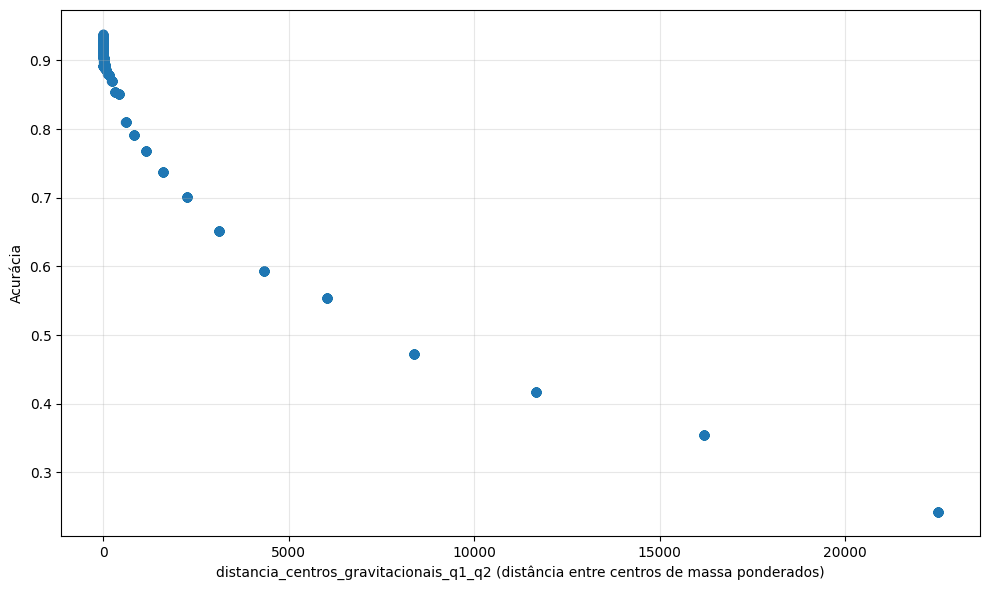

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

nome_criterio = 'distancia_centros_gravitacionais_q1_q2'
criterio = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio}'):
    arr = np.array(q1_q2[(k, h)])
    if arr.shape[0] < 3:
        criterio[(k, h)] = np.nan
        continue

    coords = arr[:, :2]
    labels = arr[:, 2]
    centro_geral = coords.mean(axis=0)

    # calcula pesos por distância inversa ao centro geral
    distancias = np.linalg.norm(coords - centro_geral, axis=1)
    pesos = 1 / (distancias + 1e-6)  # para evitar divisão por zero

    # separa por classe
    classe1 = coords[labels == 1]
    pesos1 = pesos[labels == 1]
    classe_m1 = coords[labels == -1]
    pesos_m1 = pesos[labels == -1]

    if len(classe1) == 0 or len(classe_m1) == 0:
        criterio[(k, h)] = np.nan
        continue

    centro1_ponderado = np.average(classe1, axis=0, weights=pesos1)
    centro_m1_ponderado = np.average(classe_m1, axis=0, weights=pesos_m1)

    distancia = np.linalg.norm(centro1_ponderado - centro_m1_ponderado)
    criterio[(k, h)] = distancia

df_resultados[nome_criterio] = df_resultados.apply(
    lambda row: criterio.get((row['k'], row['h']), np.nan), axis=1
)

# Gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados[nome_criterio],
            df_resultados['acuracia'],
            alpha=0.5)
plt.xlabel(nome_criterio + ' (distância entre centros de massa ponderados)')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [54]:
df_resultados.to_csv('data/df_resultados.csv', index=False)

In [51]:
df_resultados.corr()['acuracia'].iloc[3:].sort_values(ascending=True)

comprimento_fronteira_logreg_q1_q2       -0.948686
distancia_media_signed_q1_q2             -0.937271
desvio_projecao_centroide_q1_q2          -0.936981
distancia_centroides_q1_q2               -0.936949
distancia_centros_gravitacionais_q1_q2   -0.936897
diferenca_skew_q1_q2                     -0.919673
dominancia_media_anular_q1_q2            -0.731169
indice_silhueta_q1_q2                    -0.636417
angulo_vetores_classes_q1_q2             -0.611243
diferenca_inclinacao_media_q1_q2         -0.595356
mutual_information_q1_q2_y               -0.587313
variancia_pca_q1_q2                      -0.537873
media_cosseno_direcao_separacao_q1_q2    -0.392513
acuracia_logreg_q1_q2                    -0.315614
lda_separabilidade_q1_q2                 -0.108831
curvatura_fronteira_q1_q2                 0.005027
indice_fisher_q1_q2                       0.006950
q1_eq_q2_proximos                         0.124008
energia_repulsao_entre_classes_q1_q2      0.128620
proporcao_baixa_margem_q1_q2   

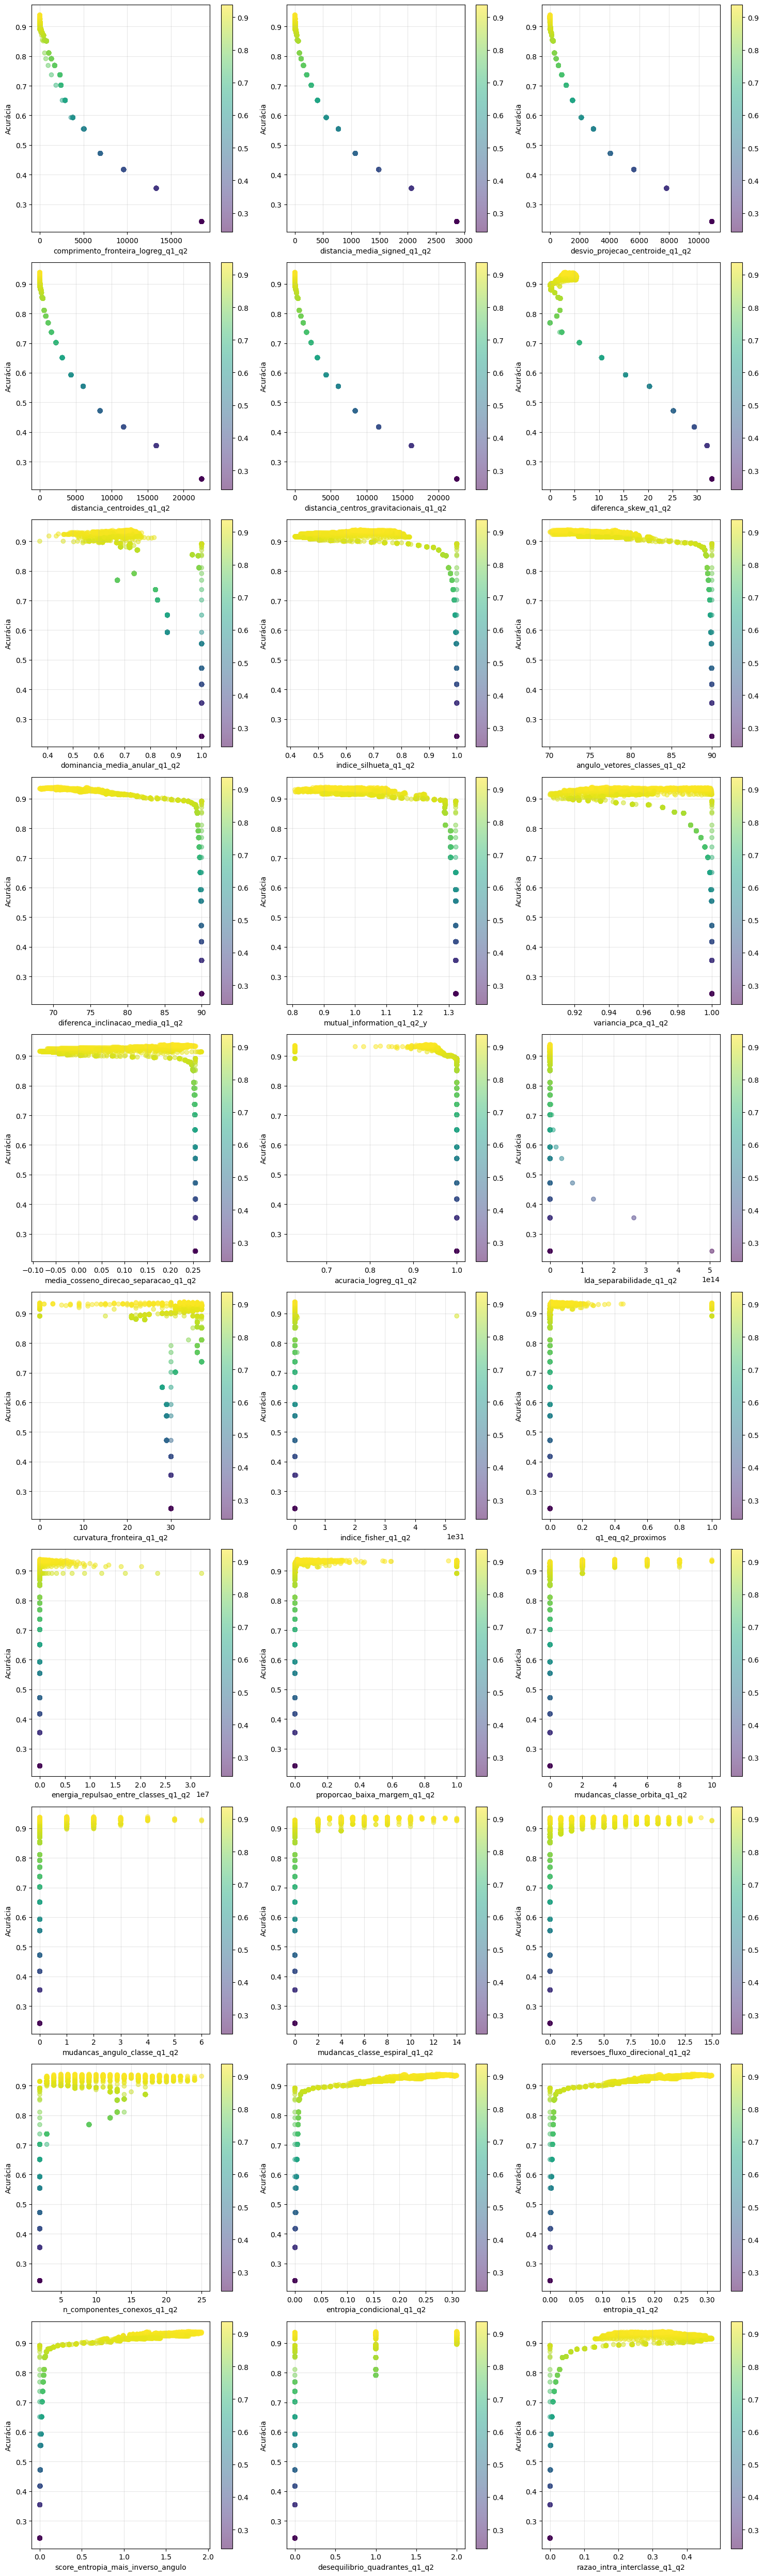

In [50]:
# Pegando as colunas ordenadas por correlação
colunas_ordenadas = df_resultados.corr()['acuracia'].iloc[3:].sort_values(ascending=True).index

# Calculando número de linhas necessário
n_plots = len(colunas_ordenadas)
n_rows = (n_plots + 2) // 3  # Arredonda para cima

plt.figure(figsize=(15, 5*n_rows))

for i, coluna in enumerate(colunas_ordenadas):
    plt.subplot(n_rows, 3, i+1)
    
    scatter = plt.scatter(df_resultados[coluna], 
                         df_resultados['acuracia'],
                         c=df_resultados['acuracia'],
                         alpha=0.5,
                         cmap='viridis')
    
    plt.xlabel(coluna)
    plt.ylabel('Acurácia')
    plt.grid(True, alpha=0.3)
    plt.colorbar(scatter)

plt.tight_layout()
plt.show()

In [42]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Cópia reduzida do DataFrame
df_comb = df_resultados[['k', 'h', 'acuracia',
                         'distancia_centroides_q1_q2',
                         'angulo_vetores_classes_q1_q2']].copy()

# --- 1. Produto Escalar Normalizado ---
# Convertendo ângulo em radianos e usando cosseno
df_comb['comb_prod_escalar'] = df_comb['distancia_centroides_q1_q2'] * np.cos(
    np.radians(df_comb['angulo_vetores_classes_q1_q2'])
)

# --- 2. Combinação Linear Normalizada ---
scaler = MinMaxScaler()
dist_ang_scaled = scaler.fit_transform(df_comb[['distancia_centroides_q1_q2',
                                                'angulo_vetores_classes_q1_q2']])
df_comb['dist_norm'] = dist_ang_scaled[:, 0]
df_comb['ang_norm'] = dist_ang_scaled[:, 1]
df_comb['comb_linear'] = df_comb['dist_norm'] * (1 - df_comb['ang_norm'])

# --- 3. Separação Orientada (distância dividida por tangente do ângulo) ---
df_comb['comb_tan'] = df_comb['distancia_centroides_q1_q2'] / (
    np.tan(np.radians(df_comb['angulo_vetores_classes_q1_q2'])) + 1e-6
)


In [43]:
df_comb

,k,h,acuracia,distancia_centroides_q1_q2,angulo_vetores_classes_q1_q2,comb_prod_escalar,dist_norm,ang_norm,comb_linear,comb_tan
0,1,0.000010,0.242105,22507.907904,90.000000,1.378212e-12,1.000000,1.000000,4.440892e-16,1.378212e-12
1,1,0.000014,0.354386,16198.618848,90.000000,9.918793e-13,0.719686,1.000000,3.196046e-16,9.918793e-13
2,1,0.000019,0.417544,11657.913907,90.000000,7.138413e-13,0.517947,1.000000,2.300149e-16,7.138413e-13
3,1,0.000027,0.471930,8390.033616,90.000000,5.137414e-13,0.372759,1.000000,1.655384e-16,5.137414e-13
4,1,0.000037,0.554386,6038.186989,90.000000,3.697323e-13,0.268270,1.000000,1.191356e-16,3.697323e-13
...,...,...,...,...,...,...,...,...,...,...
2495,99,26.826958,0.933333,0.558129,71.721978,1.750450e-01,0.000025,0.082893,2.264980e-05,1.843459e-01
2496,99,37.275937,0.935088,0.410582,71.837896,1.279810e-01,0.000018,0.088709,1.653234e-05,1.346915e-01
2497,99,51.794747,0.935088,0.300612,71.927692,9.325501e-02,0.000013,0.093215,1.202021e-05,9.809439e-02
2498,99,71.968567,0.933333,0.219239,71.996157,6.776250e-02,0.000010,0.096650,8.708766e-06,7.125124e-02


In [45]:
gamma = 2  # força da penalização do ângulo

df_comb['score_combinado_melhorado'] = df_comb['distancia_centroides_q1_q2'] * (
    1 - df_comb['angulo_vetores_classes_q1_q2'] / 90
) ** gamma


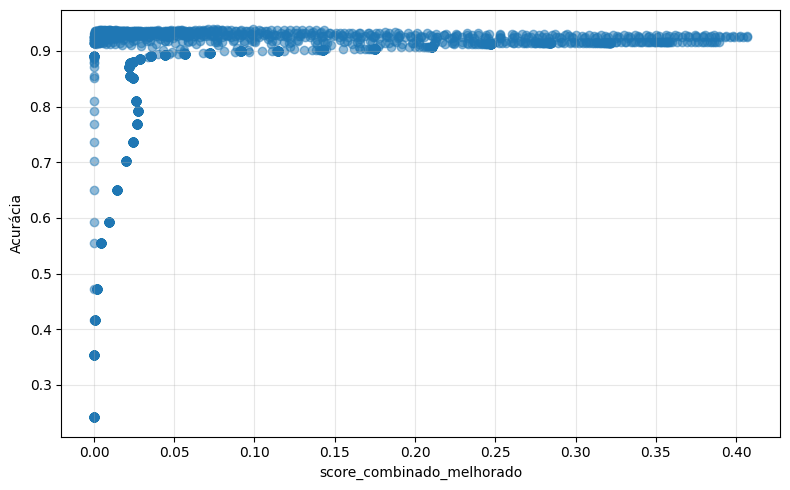

In [46]:
plt.figure(figsize=(8, 5))
plt.scatter(df_comb['score_combinado_melhorado'], df_comb['acuracia'], alpha=0.5)
plt.xlabel('score_combinado_melhorado')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [48]:
from tqdm import tqdm
from sklearn.metrics import silhouette_score
import numpy as np

# Critério 32: Índice de Silhueta
nome_criterio_32 = 'indice_silhueta_q1_q2'
criterio_32 = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio_32}'):
    arr = np.array(q1_q2[(k, h)])
    X = arr[:, :2]
    y = arr[:, 2]

    if len(np.unique(y)) < 2 or len(y) < 5:
        criterio_32[(k, h)] = np.nan
        continue

    try:
        score = silhouette_score(X, y)
    except:
        score = np.nan
    criterio_32[(k, h)] = score

df_resultados[nome_criterio_32] = df_resultados.apply(
    lambda row: criterio_32.get((row['k'], row['h']), np.nan), axis=1
)


# Critério 33: Separabilidade Linear (LDA-like)
nome_criterio_33 = 'lda_separabilidade_q1_q2'
criterio_33 = {}

for (k, h) in tqdm(q1_q2.keys(), desc=f'Calculando {nome_criterio_33}'):
    arr = np.array(q1_q2[(k, h)])
    X = arr[:, :2]
    y = arr[:, 2]

    classe1 = X[y == 1]
    classe_m1 = X[y == -1]

    if len(classe1) < 2 or len(classe_m1) < 2:
        criterio_33[(k, h)] = np.nan
        continue

    try:
        mu1 = classe1.mean(axis=0)
        mu2 = classe_m1.mean(axis=0)
        var1 = np.var(classe1, axis=0).sum()
        var2 = np.var(classe_m1, axis=0).sum()
        score = np.linalg.norm(mu1 - mu2) ** 2 / (var1 + var2 + 1e-6)
    except:
        score = np.nan

    criterio_33[(k, h)] = score

df_resultados[nome_criterio_33] = df_resultados.apply(
    lambda row: criterio_33.get((row['k'], row['h']), np.nan), axis=1
)


Calculando lda_separabilidade_q1_q2: 100%|██████████| 2500/2500 [00:00<00:00, 4295.57it/s]


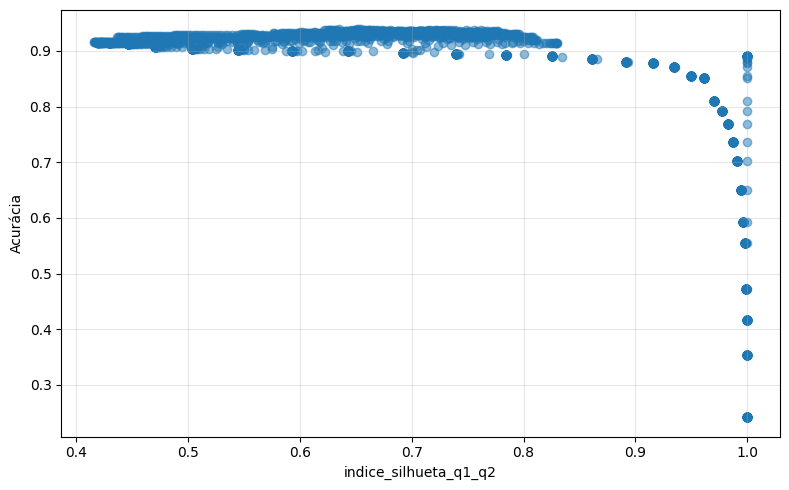

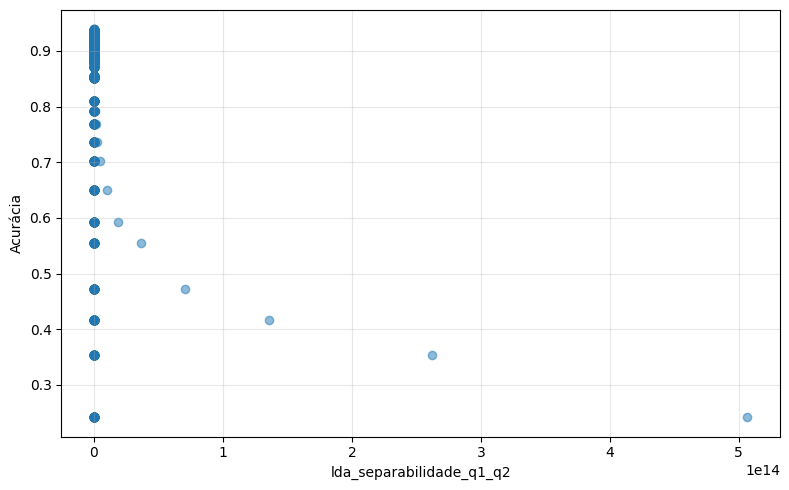

In [49]:
import matplotlib.pyplot as plt

for nome in [nome_criterio_32, nome_criterio_33]:
    plt.figure(figsize=(8, 5))
    plt.scatter(df_resultados[nome], df_resultados['acuracia'], alpha=0.5)
    plt.xlabel(nome)
    plt.ylabel('Acurácia')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
